In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns

from dotenv import load_dotenv
from functools import reduce
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, log_loss, mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor, plot_importance

%matplotlib inline
plt.style.use("ggplot")
sns.set_context("talk")

Using TensorFlow backend.


In [2]:
load_dotenv("")
FREDkey = os.getenv("FREDkey")

In [7]:
varlist = ["WILL5000INDFC",
           "NIKKEI225",
           "CPIAUCSL",
           "CPIFABSL",
           "CPIHOSSL",
           "IC4WSA",
           "INDPRO",
           "IPMAN",
           "HOUST",
           "HSN1F",
           "RELACBW027SBOG",
           "MSPNHSUS",
           "USSTHPI",
           "AHETPI",
           "PCE",
           "PCEND",
           "DAUTOSAAR",
           "PI",
           "A229RX0",
           "DEXJPUS",
           "DTWEXM",
           "DGS30",
           "DGS10",
           "DGS2",
           "DGS5",
           "DTB3",
           "MORTGAGE30US",
           "AAA",
           "BAA",
           "BAMLCC0A0CMTRIV",
           "FEDFUNDS",
           "TB3SMFFM",
           "UMCSENT",  
           "CIVPART",
           "TCU",
           "UNRATE",
           "LNS14000002",
           "LNS15000000",
           "UEMPMEAN",
           "USCONS",
           "NFCI",
           "USRECDM",
           "GDPPOT",
           "GDPC1",
           "GOLDPMGBD228NLBM",
           "WTISPLC",
           "CMRMTSPL",
#            "TERMCBAUTO48NS",
           "TERMCBPER24NS",
           "NONREVSL",
           "CEFDFSA066MSFRBPHI",
           "M1SL",
           "MABMM301USM189S",
           "TOTALSA",
           "PSAVERT",
           "TOTCI",
           "TOTLL",
           "TOTBKCR",
           "DPRIME",
           "MSACSR",
           "PPIACO",
           "PERMIT",
           "DSPIC96",
           "TLAACBW027SBOG",
           "M12MTVUSM227NFWA",
           "AWHMAN",
           "CCSA",
           "TCD",
           "CSCICP03USM665S"
          ]

In [8]:
datalist=[]
for var in varlist:
    resp = requests.get(
        "https://api.stlouisfed.org/fred/series/observations?series_id={}&api_key={}&file_type=json"
        .format(var, 
                FREDkey))
    df = pd.DataFrame(resp.json()['observations'])
    df.date = pd.to_datetime(df.date)
    df = df.loc[df.value!="."]
    df.value = df.value.astype(float)
    df.index = df.date
    df.drop(columns=["realtime_end", "realtime_start", "date"], axis=1, inplace=True)
    df.columns=[var]
    df= df.resample("1D").interpolate(method='linear')
    datalist.append(df)
#     print(var)

WILL5000INDFC
NIKKEI225
CPIAUCSL
CPIFABSL
CPIHOSSL
IC4WSA
INDPRO
IPMAN
HOUST
HSN1F
RELACBW027SBOG
MSPNHSUS
USSTHPI
AHETPI
PCE
PCEND
DAUTOSAAR
PI
A229RX0
DEXJPUS
DTWEXM
DGS30
DGS10
DGS2
DGS5
DTB3
MORTGAGE30US
AAA
BAA
BAMLCC0A0CMTRIV
FEDFUNDS
TB3SMFFM
UMCSENT
CIVPART
TCU
UNRATE
LNS14000002
LNS15000000
UEMPMEAN
USCONS
NFCI
USRECDM
GDPPOT
GDPC1
GOLDPMGBD228NLBM
WTISPLC
CMRMTSPL
TERMCBPER24NS
NONREVSL
CEFDFSA066MSFRBPHI
M1SL
MABMM301USM189S
TOTALSA
PSAVERT
TOTCI
TOTLL
TOTBKCR
DPRIME
MSACSR
PPIACO
PERMIT
DSPIC96
TLAACBW027SBOG
M12MTVUSM227NFWA
AWHMAN
CCSA
TCD
CSCICP03USM665S


In [9]:
df_merged = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), datalist)

In [10]:
df_merged.shape

(63858, 68)

In [11]:
df_merged["2-10"] = df_merged.DGS10 - df_merged.DGS2
df_merged["10-30"] = df_merged.DGS30 - df_merged.DGS10
df_merged["positive_gap"] = df_merged.GDPC1.pct_change(365) - df_merged.GDPPOT.pct_change(365) > 0
df_merged["gap"] = df_merged.GDPC1.pct_change(365) - df_merged.GDPPOT.pct_change(365)
df_WILL5000_5d_vol = df_merged.WILL5000INDFC.pct_change(1).rolling(5).std()
df_WILL5000_30d_vol = df_merged.WILL5000INDFC.pct_change(1).rolling(30).std()

In [12]:
df_WILL5000_5d_vol= df_WILL5000_5d_vol.loc[df_merged.DGS30>-10].resample("1W").mean()
df_WILL5000_30d_vol= df_WILL5000_30d_vol.loc[df_merged.DGS30>-10].resample("1W").mean()
df_merged = df_merged.loc[df_merged.DGS30>-10].resample("1W").mean()

In [13]:
percent = ["WILL5000INDFC",
           "NIKKEI225",
           "CPIAUCSL", 
           "CPIFABSL",
           "CPIHOSSL",
           "IC4WSA",
           "INDPRO",
           "IPMAN",
           "HOUST",
           "HSN1F",
           "RELACBW027SBOG",
           "MSPNHSUS",
           "USSTHPI",
           "AHETPI",
           "PCE",
           "PCEND",
           "DAUTOSAAR",
           "A229RX0",
           "DEXJPUS",
           "DTWEXM",
           "GOLDPMGBD228NLBM",
           "WTISPLC",
           "BAMLCC0A0CMTRIV",
           "CMRMTSPL",
           "NONREVSL",
           "M1SL",
           "MABMM301USM189S",
           "TOTALSA",
           "TOTCI",
           "TOTLL",
           "TOTBKCR",
           "PPIACO",
           "PERMIT",
           "DSPIC96",
           "TLAACBW027SBOG",
           "M12MTVUSM227NFWA",
           "PI",
           "AWHMAN",
           "CCSA",
           "TCD",
           "UEMPMEAN",
           "LNS15000000",
           "USCONS"
          ]

In [17]:
actual = ["DGS30",
          "DGS10",
          "DGS2",
          "DGS5",
          "DTB3",
          "MORTGAGE30US",
          "AAA",
          "BAA",
          "FEDFUNDS",
          "TB3SMFFM",
          "UMCSENT",  
          "CIVPART",
          "TCU",
          "UNRATE",
          "LNS14000002",
          "NFCI",
          "2-10",
          "10-30",
          "gap",
#           "TERMCBAUTO48NS",
          "TERMCBPER24NS",
          "CEFDFSA066MSFRBPHI",
          "PSAVERT",
          "DPRIME",
          "MSACSR",
          "CSCICP03USM665S"
         ]

In [15]:
def change(df, percent, actual, period):
    df_actual = df[actual].diff(period).fillna(method='ffill')

    df_percent = df[percent].pct_change(period).fillna(method='ffill')
    df_concat = pd.concat([df_actual, df_percent], axis=1)
    df_concat.columns = [str(col) + '_{}'.format(period) for col in df_concat.columns]
    return df_concat

In [18]:
week = change(df_merged, percent, actual, 1)
week_week = week.diff(1).add_suffix("_1")
month = change(df_merged, percent, actual, 4)
month_month = month.diff(4).add_suffix("_4")
three_m = change(df_merged, percent, actual, 13)
three_three = three_m.diff(13).add_suffix("_13")
six_m = change(df_merged, percent, actual, 26)
six_six = six_m.diff(26).add_suffix("_26")
one_y = change(df_merged, percent, actual, 52)

In [19]:
X = pd.concat([week, 
               week_week, 
               month, 
               month_month, 
               three_m, 
               three_three, 
               six_m, 
               six_six, 
               one_y,
               df_merged[actual].fillna(method="ffill"),
               df_merged[actual].fillna(method="ffill").shift(1),
               df_merged[actual].fillna(method="ffill").shift(4),
               df_merged[actual].fillna(method="ffill").shift(13),
               df_merged[actual].fillna(method="ffill").shift(26),
               df_merged[actual].fillna(method="ffill").shift(52),
               df_WILL5000_5d_vol,
               df_WILL5000_30d_vol
              ], axis=1)[52:]

In [20]:
# X = pd.concat([week, 
#                week_week, 
#                month, 
#                month_month, 
#                three_m, 
#                three_three, 
#                six_m, 
#                six_six, 
#                one_y,
#               ], axis=1)[52:]

In [21]:
y1w = df_merged.positive_gap.shift(-1)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
y1m = df_merged.positive_gap.shift(-4)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
y3m = df_merged.positive_gap.shift(-13)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
y6m = df_merged.positive_gap.shift(-26)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
y12m = df_merged.positive_gap.shift(-52)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)

In [22]:
# GDPC1y1w = df_merged.USREC.shift(-1)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
# y1m = df_merged.USREC.shift(-4)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
# y3m = df_merged.USREC.shift(-13)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
# y6m = df_merged.USREC.shift(-26)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
# y12m = df_merged.USREC.shift(-52)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)

In [17]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

In [18]:
X.isnull().sum().sort_values(ascending=False)

WILL5000INDFC             0
RELACBW027SBOG_4_4        0
PERMIT_4_4                0
PPIACO_4_4                0
TOTBKCR_4_4               0
TOTLL_4_4                 0
TOTCI_4_4                 0
TOTALSA_4_4               0
MABMM301USM189S_4_4       0
M1SL_4_4                  0
NONREVSL_4_4              0
CMRMTSPL_4_4              0
BAMLCC0A0CMTRIV_4_4       0
WTISPLC_4_4               0
GOLDPMGBD228NLBM_4_4      0
DTWEXM_4_4                0
DEXJPUS_4_4               0
A229RX0_4_4               0
DAUTOSAAR_4_4             0
PCEND_4_4                 0
PCE_4_4                   0
AHETPI_4_4                0
USSTHPI_4_4               0
DSPIC96_4_4               0
TLAACBW027SBOG_4_4        0
M12MTVUSM227NFWA_4_4      0
DTB3_13                   0
UNRATE_13                 0
TCU_13                    0
CIVPART_13                0
                         ..
UMCSENT_26_26             0
TB3SMFFM_26_26            0
FEDFUNDS_26_26            0
BAA_26_26                 0
AAA_26_26           

In [19]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

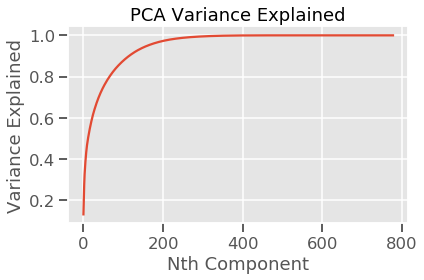

In [20]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title("PCA Variance Explained")
plt.xlabel("Nth Component")
plt.ylabel("Variance Explained")
plt.tight_layout()
plt.savefig("../images/pca")

In [21]:
n_pc = 150

In [22]:
X_train = X_pca[:int(X_pca.shape[0]*0.7), :n_pc]
X_test = X_pca[int(X_pca.shape[0]*0.7):, :n_pc]

In [23]:
X_train.shape

(1521, 150)

In [24]:
y1w.shape

(2173,)

In [25]:
y1w_train = y1w[:int(X_pca.shape[0]*0.7)]
y1w_test = y1w[int(X_pca.shape[0]*0.7):]

In [26]:
clf = SVC(C=0.1, gamma=0.001, probability=True)
clf.fit(X_train, y1w_train)
confusion_matrix(clf.predict(X_test), y1w_test)

array([[121,  27],
       [107, 397]])

In [27]:
clf.score(X_train, y1w_train)

0.8974358974358975

In [28]:
clf.score(X_test, y1w_test)

0.7944785276073619

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


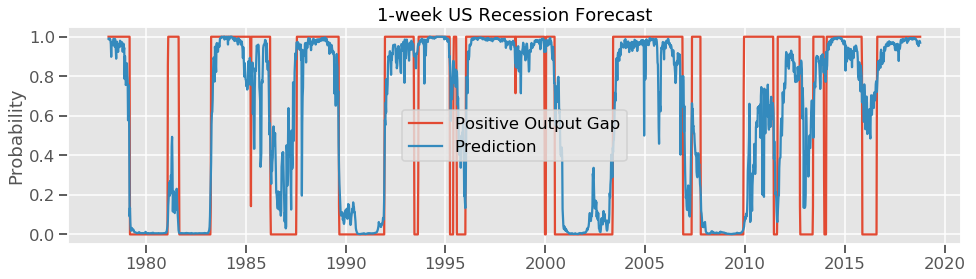

In [29]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("1-week US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/1w_gap_svc")
plt.show()

In [30]:
y1m_train = y1m[:int(X_pca.shape[0]*0.7)]
y1m_test = y1m[int(X_pca.shape[0]*0.7):]

In [31]:
clf = SVC(C=20, gamma=0.00001, probability=True)
clf.fit(X_train, y1m_train)
print(confusion_matrix(clf.predict(X_test), y1m_test))
print("train:", clf.score(X_train, y1m_train))
print("test", clf.score(X_test, y1m_test))

[[123  37]
 [106 386]]
train: 0.9513477975016437
test 0.7806748466257669


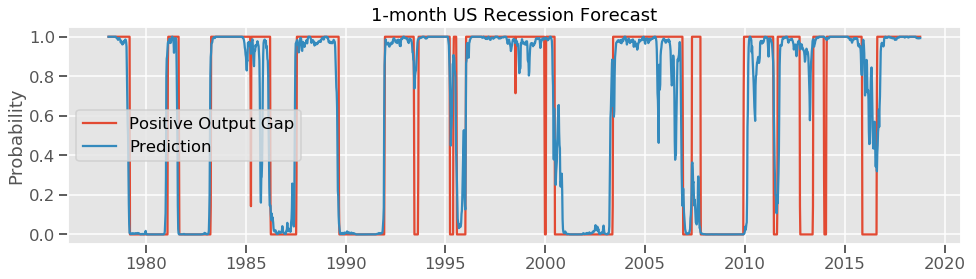

In [32]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("1-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/1m_gap_svc")
plt.show()

In [33]:
y3m_train = y3m[:int(X_pca.shape[0]*0.7)]
y3m_test = y3m[int(X_pca.shape[0]*0.7):]

In [34]:
clf = SVC(C=20, gamma=0.00001, probability=True)
clf.fit(X_train, y3m_train)
print(confusion_matrix(clf.predict(X_test), y3m_test))
print("train:", clf.score(X_train, y3m_train))
print("test", clf.score(X_test, y3m_test))

[[110  12]
 [128 402]]
train: 0.9546351084812623
test 0.7852760736196319


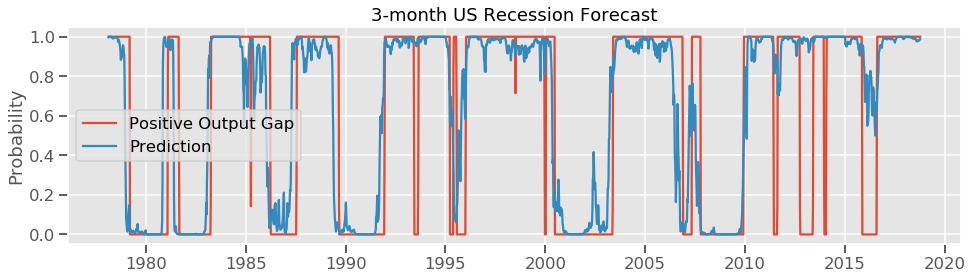

In [35]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("3-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/3m_gap_svc")
plt.show()

In [36]:
clf = RandomForestClassifier(max_features=120, 
                             n_estimators=60, 
                             max_depth=8, 
                             min_samples_leaf=100, 
                             random_state=0,
                             class_weight="balanced"
                            )
clf.fit(X_train, y3m_train)
print(confusion_matrix(clf.predict(X_test), y3m_test))
print("train:", clf.score(X_train, y3m_train))
print("test", clf.score(X_test, y3m_test))

[[225 226]
 [ 13 188]]
train: 0.8211702827087443
test 0.6334355828220859


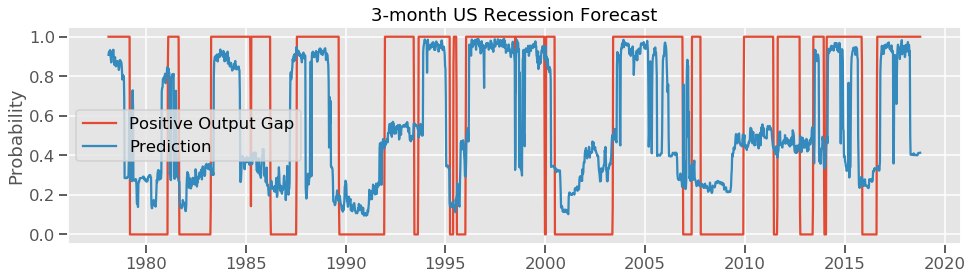

In [37]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("3-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/3m_gap_rfc")
plt.show()

In [38]:
y6m_train = y6m[:int(X_pca.shape[0]*0.7)]
y6m_test = y6m[int(X_pca.shape[0]*0.7):]

In [39]:
clf = SVC(C=35,
          gamma=0.00001,
          probability=True)
clf.fit(X_train, y6m_train)
print(confusion_matrix(clf.predict(X_test), y6m_test))
print(clf.score(X_train, y6m_train))
print(clf.score(X_test, y6m_test))

[[ 75   4]
 [176 397]]
0.9493754109138725
0.7239263803680982


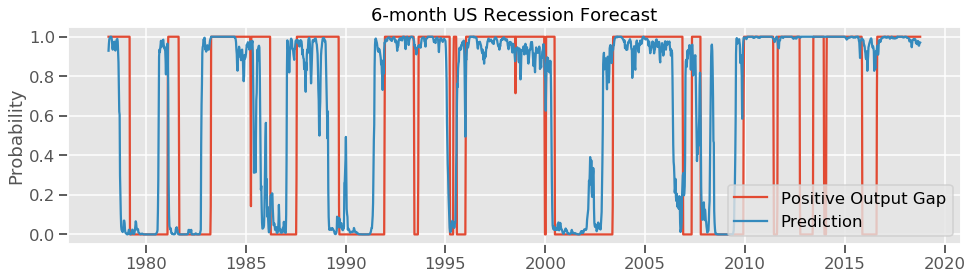

In [40]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("6-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"], loc=4)
plt.savefig("../images/6m_gap_svc")
plt.show()

In [41]:
clf = RandomForestClassifier(max_features=100, 
                             n_estimators=30, 
                             max_depth=8, 
                             min_samples_leaf=100, 
                             random_state=0,
                             class_weight="balanced"
                            )
clf.fit(X_train, y6m_train)
print(confusion_matrix(clf.predict(X_test), y6m_test))
print(clf.score(X_train, y6m_train))
print(clf.score(X_test, y6m_test))

[[153  35]
 [ 98 366]]
0.8270874424720579
0.7960122699386503


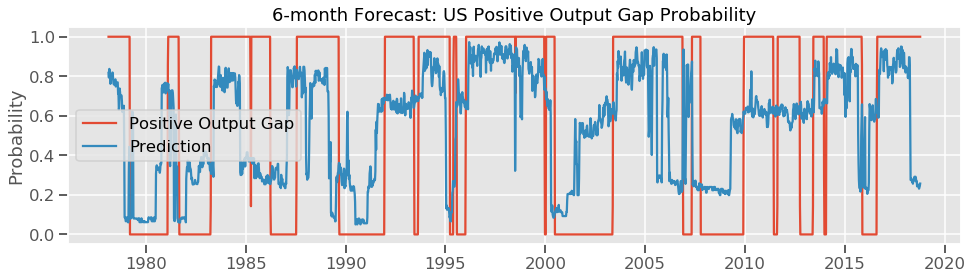

In [42]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("6-month Forecast: US Positive Output Gap Probability")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"], loc=0)
plt.savefig("../images/6m_gap_rfc")
plt.show()

In [43]:
y12m_train = y12m[:int(X_pca.shape[0]*0.7)]
y12m_test = y12m[int(X_pca.shape[0]*0.7):]

[[ 29  20]
 [222 381]]
0.8474687705456936
0.6288343558282209


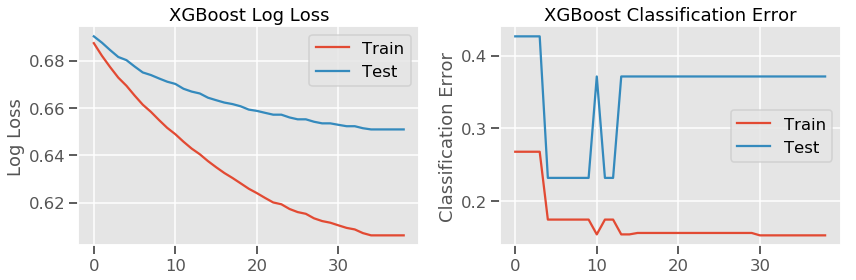

In [44]:
clf = XGBClassifier(max_depth=2, 
                    learning_rate=0.1, 
                    n_estimators=200,
                    gamma=1,
                    random_state=0,
                    scale_pos_weight=y6m_train.value_counts()[0]/y6m_train.value_counts()[1],
                    reg_alpha=100,
                    reg_lambda=100
                   )
clf.fit(X_train, 
        y6m_train, 
        eval_set = [(X_train, y6m_train), (X_test, y6m_test)],
        eval_metric=["error", "logloss"],
        early_stopping_rounds=5, 
        verbose=False
       )
print(confusion_matrix(clf.predict(X_test), y6m_test))
print(clf.score(X_train, y6m_train))
print(clf.score(X_test, y6m_test))

# retrieve performance metrics
results = clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].plot(x_axis, results['validation_0']['logloss'], label='Train')
ax[0].plot(x_axis, results['validation_1']['logloss'], label='Test')
ax[0].legend()
ax[0].set_ylabel('Log Loss')
ax[0].set_title('XGBoost Log Loss')
# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_ylabel('Classification Error')
ax[1].set_title('XGBoost Classification Error')
plt.tight_layout()
plt.show()

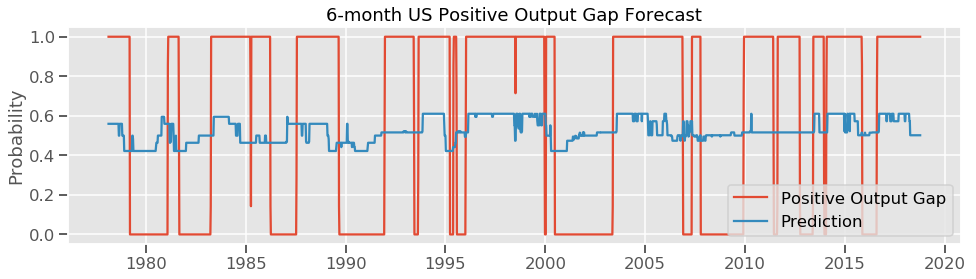

In [45]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("6-month US Positive Output Gap Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"], loc=4)
plt.savefig("../images/6m_gap_xgc")
plt.show()

In [46]:
xgc_scores = {}
xgc_feature_sets = []
k=0
for i in range(0, 100, 10):
    for j in range(0, 100, 10):
        xgc = XGBClassifier(reg_alpha=i, reg_lambda=j)
        xgc.fit(X_train,
                y6m_train,
                eval_set = [(X_train, y6m_train), (X_test, y6m_test)],
                eval_metric=["error", "logloss"],
                early_stopping_rounds=5,
                verbose=False)

        
        xgc_features = pd.DataFrame(xgc.feature_importances_, 
                                    columns=["importance"]
                                   ).sort_values(by="importance",
                                                 ascending=False) 
                                
        xgc_scores[k] = [i,
                         j,
                         clf.evals_result()['validation_0']['logloss'][-1],
                         clf.evals_result()['validation_1']['logloss'][-1],
                         clf.evals_result()['validation_0']['error'][-1],
                         clf.evals_result()['validation_1']['error'][-1],
                         np.sum(xgc_features.importance>0)]
        xgc_feature_sets.append(xgc_features)
        k += 1
        if k%10 ==0:
            print("Progress: {}% completed".format(k))

Progress: 10% completed
Progress: 20% completed
Progress: 30% completed
Progress: 40% completed
Progress: 50% completed
Progress: 60% completed
Progress: 70% completed
Progress: 80% completed
Progress: 90% completed
Progress: 100% completed


In [47]:
xgc_reg_score = pd.DataFrame(xgc_scores, 
                             index=["alpha",
                                    "lambda",
                                    "train_log_loss",
                                    "test_log_loss",
                                    "train_error",
                                    "test_error",
                                    "n_features"
                                   ]).T

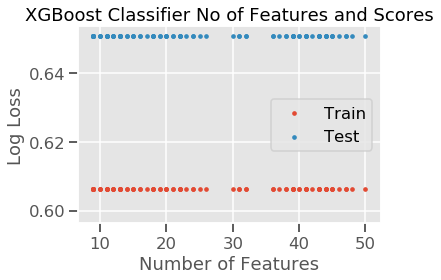

In [48]:
plt.scatter(xgc_reg_score.n_features, 
            xgc_reg_score.train_log_loss,
            s=10
           )
plt.scatter(xgc_reg_score.n_features,
            xgc_reg_score.test_log_loss,
            s=10
           )
plt.title("XGBoost Classifier No of Features and Scores")
plt.ylabel("Log Loss")
plt.xlabel("Number of Features")
plt.legend(["Train","Test"])
plt.tight_layout()
plt.savefig("../images/output_gap_xgc_reg_log_loss_6m")

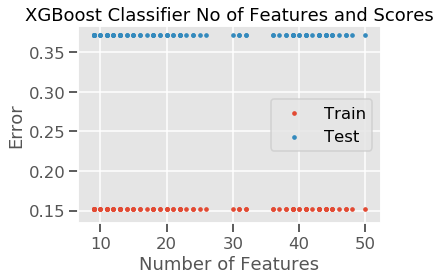

In [49]:
plt.scatter(xgc_reg_score.n_features, 
            xgc_reg_score.train_error,
            s=10
           )
plt.scatter(xgc_reg_score.n_features,
            xgc_reg_score.test_error,
            s=10
           )
plt.title("XGBoost Classifier No of Features and Scores")
plt.ylabel("Error")
plt.xlabel("Number of Features")
plt.legend(["Train","Test"])
plt.tight_layout()
plt.savefig("../images/output_gap_xgc_reg_error_6m")

In [50]:
y12m_train = y12m[:int(X_pca.shape[0]*0.7)]
y12m_test = y12m[int(X_pca.shape[0]*0.7):]

In [51]:
clf = SVC(C=100, 
          gamma=0.000005, 
          probability=True,
          random_state=0,
          class_weight="balanced"
         )
clf.fit(X_train, y12m_train)
print(confusion_matrix(clf.predict(X_test), y12m_test))
print("train:", clf.score(X_train, y12m_train))
print("test:", clf.score(X_test, y12m_test))

[[108  29]
 [143 372]]
train: 0.9263642340565418
test: 0.7361963190184049


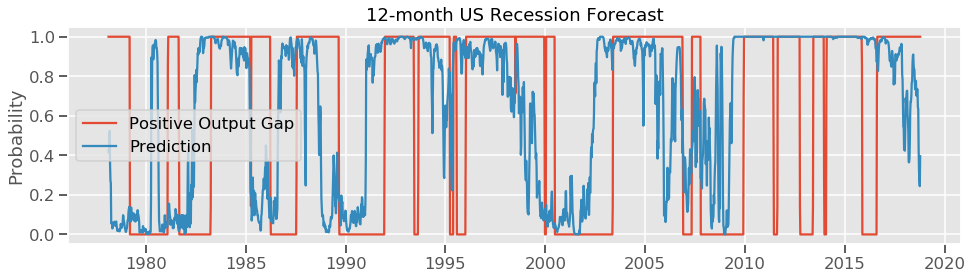

In [52]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/12m_gap_svc")
plt.show()

In [53]:
y12m_train.value_counts()[1]/y12m_train.value_counts()[0]

1.4532258064516128

In [54]:
clf = RandomForestClassifier(max_features=100, 
                             n_estimators=70, 
                             max_depth=30, 
                             min_samples_leaf=50,
                             random_state=0, 
                             class_weight="balanced"
                            )
clf.fit(X_train, 
        y12m_train)
print(confusion_matrix(clf.predict(X_test), y12m_test))
print("train:", clf.score(X_train, y12m_train))
print("test:", clf.score(X_test, y12m_test))

[[125  21]
 [126 380]]
train: 0.8783694937541091
test: 0.7745398773006135


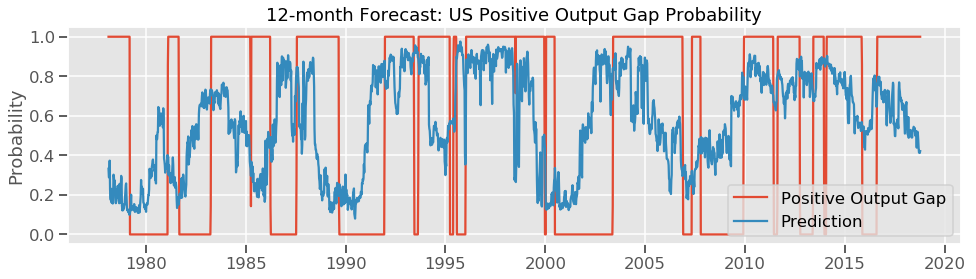

In [55]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("12-month Forecast: US Positive Output Gap Probability")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"], loc=4)
plt.savefig("../images/12m_gap_rfc")
plt.show()

[[ 84   0]
 [167 401]]
train: 0.7738330046022354
test: 0.7438650306748467


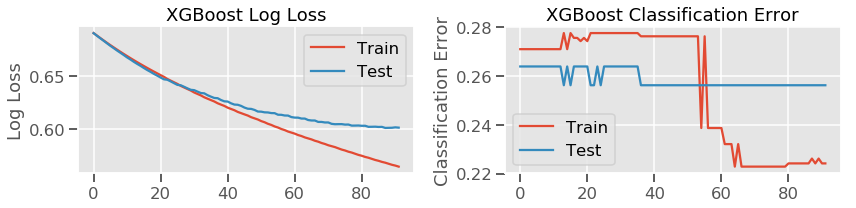

In [56]:
clf = XGBClassifier(max_depth=2, 
                    learning_rate=0.01, 
                    n_estimators=200,
                    gamma=1,
                    scale_pos_weight=y6m_train.value_counts()[0]/y6m_train.value_counts()[1]
                   )
clf.fit(X_train, 
        y12m_train, 
        eval_set = [(X_train, y12m_train), (X_test, y12m_test)],
        eval_metric=["error", "logloss"],
        early_stopping_rounds=5,
        verbose=False
       )
print(confusion_matrix(clf.predict(X_test), y12m_test))
print("train:", clf.score(X_train, y12m_train))
print("test:", clf.score(X_test, y12m_test))

# retrieve performance metrics
results = clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
ax[0].plot(x_axis, results['validation_0']['logloss'], label='Train')
ax[0].plot(x_axis, results['validation_1']['logloss'], label='Test')
ax[0].legend()
ax[0].set_ylabel('Log Loss')
ax[0].set_title('XGBoost Log Loss')
# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_ylabel('Classification Error')
ax[1].set_title('XGBoost Classification Error')
plt.tight_layout()
plt.show()

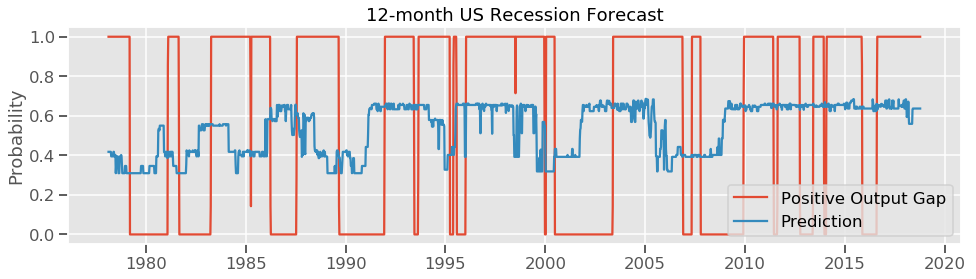

In [57]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"], loc=4)
plt.savefig("../images/12m_gap_xgc")
plt.show()

In [58]:
xgc_scores = {}
xgc_feature_sets = []
k=0
for i in range(0, 100, 10):
    for j in range(0, 100, 10):
        xgc = XGBClassifier(reg_alpha=i, reg_lambda=j)
        xgc.fit(X_train, y12m_train)

        
        xgc_features = pd.DataFrame(xgc.feature_importances_, 
                                    columns=["importance"]
                                   ).sort_values(by="importance",
                                                 ascending=False) 
                                
        xgc_scores[k] = [i,
                         j,
                         xgc.score(X_train, y12m_train),
                         xgc.score(X_test, y12m_test),
                         np.sum(xgc_features.importance>0)]
        xgc_feature_sets.append(xgc_features)
        k += 1

In [59]:
xgc_reg_score = pd.DataFrame(xgc_scores, 
                             index=["alpha",
                                    "lambda",
                                    "train",
                                    "test",
                                    "n_features"
                                   ]).T

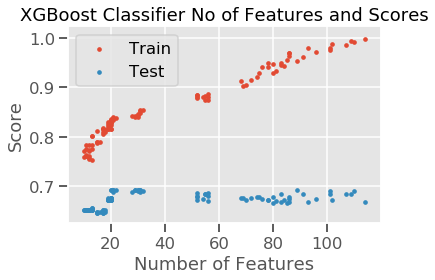

In [60]:
plt.scatter(xgc_reg_score.n_features, 
            xgc_reg_score.train,
            s=10
           )
plt.scatter(xgc_reg_score.n_features,
            xgc_reg_score.test,
            s=10
           )
plt.title("XGBoost Classifier No of Features and Scores")
plt.ylabel("Score")
plt.xlabel("Number of Features")
plt.legend(["Train","Test"])
plt.tight_layout()
plt.savefig("../images/output_gap_xgc_reg_score_12m")

In [17]:
actual = ["DGS30",
          "DGS10",
          "DGS2",
          "DGS5",
          "DTB3",
          "MORTGAGE30US",
          "AAA",
          "BAA",
          "FEDFUNDS",
          "TB3SMFFM",
          "UMCSENT",  
          "CIVPART",
          "TCU",
          "UNRATE",
          "LNS14000002",
          "NFCI",
          "2-10",
          "10-30",
#           "gap",
          "TERMCBAUTO48NS",
          "TERMCBPER24NS",
          "CEFDFSA066MSFRBPHI",
          "PSAVERT",
          "DPRIME",
          "MSACSR",
          "CSCICP03USM665S"
         ]

In [23]:
week = change(df_merged, percent, actual, 1)
week_week = week.diff(1).add_suffix("_1")
month = change(df_merged, percent, actual, 4)
month_month = month.diff(4).add_suffix("_4")
three_m = change(df_merged, percent, actual, 13)
three_three = three_m.diff(13).add_suffix("_13")
six_m = change(df_merged, percent, actual, 26)
six_six = six_m.diff(26).add_suffix("_26")
one_y = change(df_merged, percent, actual, 52)

In [24]:
X = pd.concat([week, 
               week_week, 
               month, 
               month_month, 
               three_m, 
               three_three, 
               six_m, 
               six_six, 
               one_y,
               df_merged[actual].fillna(method="ffill"),
               df_merged[actual].fillna(method="ffill").shift(1),
               df_merged[actual].fillna(method="ffill").shift(4),
               df_merged[actual].fillna(method="ffill").shift(13),
               df_merged[actual].fillna(method="ffill").shift(26),
               df_merged[actual].fillna(method="ffill").shift(52),
               df_WILL5000_5d_vol,
               df_WILL5000_30d_vol
              ], axis=1)[52:]

In [25]:
X_gap = pd.concat([df_merged.gap,
#                    pd.DataFrame(df_merged.gap.diff(1)).add_suffix("_diff"),
#                    pd.DataFrame(df_merged.gap.diff(1).diff(1)).add_suffix("_diff_diff")
                  ], axis=1)[52:]

In [26]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

In [27]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [28]:
X_pca_gap = np.concatenate([np.array(X_gap), X_pca], axis=1)

In [29]:
X_pca_gap.shape

(2175, 765)

In [30]:
n_pc = 150

In [31]:
X_train_gap = X_pca_gap[:int(X_pca.shape[0]*0.7), :n_pc]
X_test_gap = X_pca_gap[int(X_pca.shape[0]*0.7):, :n_pc]

In [32]:
g1w = df_merged.gap.shift(-1)[X.index].fillna(method="ffill")
g1m = df_merged.gap.shift(-4)[X.index].fillna(method="ffill")
g3m = df_merged.gap.shift(-13)[X.index].fillna(method="ffill")
g6m = df_merged.gap.shift(-26)[X.index].fillna(method="ffill")
g12m = df_merged.gap.shift(-52)[X.index].fillna(method="ffill")

In [33]:
g6m_train = g6m[:int(X_pca.shape[0]*0.7)]
g6m_test = g6m[int(X_pca.shape[0]*0.7):]
g12m_train = g12m[:int(X_pca.shape[0]*0.7)]
g12m_test = g12m[int(X_pca.shape[0]*0.7):]

In [74]:
# tscv = TimeSeriesSplit(n_splits=5)
# i = 1
# score_dict = {}
# for train_index, test_index in tscv.split(X_train):
#     X_tr, X_tst = X_train[train_index], X_train[test_index]
#     y_tr, y_tst = g12m_train[train_index], g12m_train[test_index]
#     score = 0
#     for c in [np.logspace(-10, 10, 2)]:
#         for e in [np.logspace(-20, 0, 2)]:
#             svm = SVR(C=c, epsilon=e, gamma="auto")
#             svm.fit(X_tr, y_tr)
#             if score < svm.score(X_tst, y_tst):
#                 score_dict[i] = [c, e, svm.score(X_tst, y_tst)]
#     i += 1

In [75]:
svm = SVR(C=50, 
          epsilon=10**-7, 
          gamma="auto")
svm.fit(X_train_gap, g6m_train)
print("train", svm.score(X_train_gap, g6m_train))
print("test", svm.score(X_test_gap, g6m_test))

train 0.9998319466708583
test 0.11739149169396701


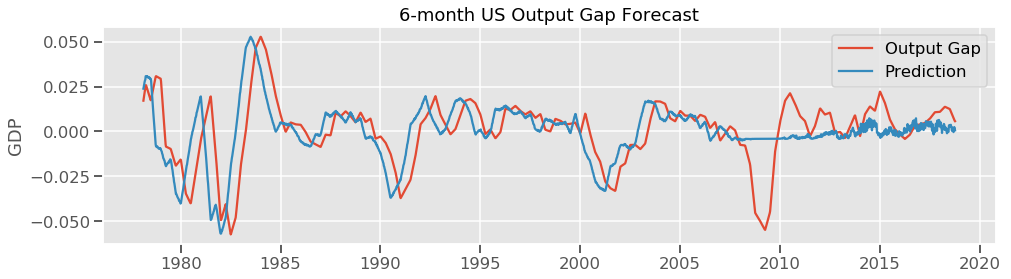

In [76]:
pred = pd.DataFrame(svm.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("6-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/6m_gap_svm")
plt.show()

In [77]:
# tscv = TimeSeriesSplit(n_splits=5)
# i = 1
# score_dict = {}
# for train_index, test_index in tscv.split(X_train):
#     X_tr, X_tst = X_train[train_index], X_train[test_index]
#     y_tr, y_tst = g12m_train[train_index], g12m_train[test_index]
#     score = 0
#     for mf in np.linspace(10, 100, 10):
#         for ne in np.linspace(10, 30, 11):
#             for md in np.linspace(5, 25, 11):
#                 for msl in np.linspace(10, 40, 16):
#                     rfr = RandomForestRegressor(max_features=int(mf),
#                                                 n_estimators=int(ne), 
#                                                 max_depth=int(md),
#                                                 min_samples_leaf=int(msl)
#                                                )
#                     rfr.fit(X_tr, y_tr)
#                     if score < rfr.score(X_tst, y_tst):
#                         score_dict[i] = [mf, ne, md, msl, rfr.score(X_tst, y_tst)]
#     i += 1

In [78]:
# score_dict

In [79]:
rfr = RandomForestRegressor(max_features=50,
                            n_estimators=50, 
                            max_depth=20, 
                            min_samples_leaf=30,
                            random_state=0
                           )
rfr.fit(X_train_gap, g6m_train)
print("train: ", rfr.score(X_train_gap, g6m_train))
print("test: ", rfr.score(X_test_gap, g6m_test))

train:  0.8506084181489519
test:  0.6139051558136175


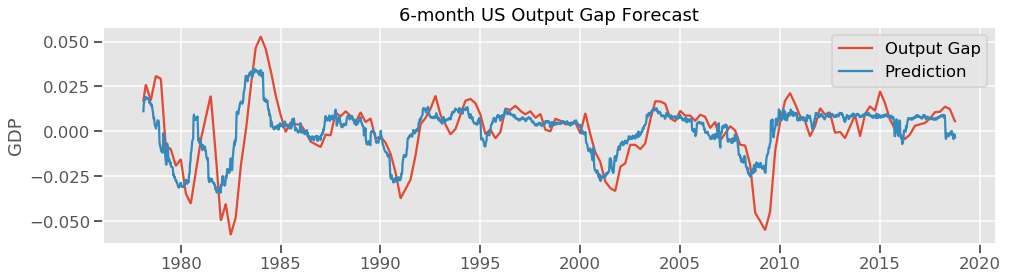

In [80]:
pred = pd.DataFrame(rfr.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("6-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/6m_gap_rfr")
plt.show()

In [81]:
xgr = XGBRegressor(max_depth=3, 
                   min_child_weight=20,
                   gamma=0,
                   subsample=0.95,
                   colsample_bytree=1,
                   learning_rate=0.3, 
                   n_estimators=200,
                   reg_alpha=0.001,
                   random_state=0
                  )
xgr.fit(X_train_gap,
        g6m_train,
        eval_set=[(X_train_gap, g6m_train), (X_test_gap, g6m_test)],
        early_stopping_rounds=10,
        verbose=False)
print("train", xgr.score(X_train_gap, g6m_train))
print("test", xgr.score(X_test_gap, g6m_test))

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[09:13:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train 0.9495790346948754
test 0.5038748264801646


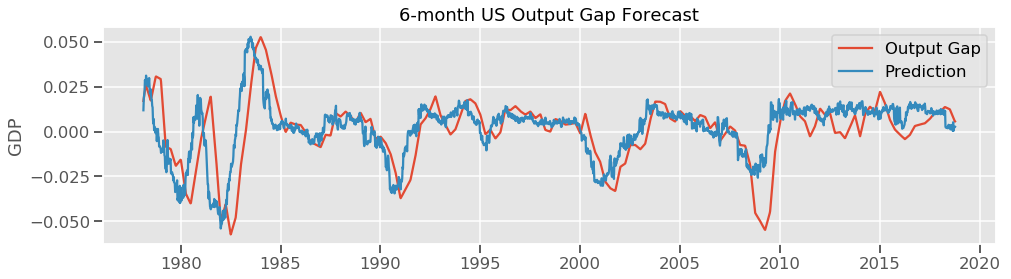

In [82]:
pred = pd.DataFrame(xgr.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("6-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/6m_gap_xgr")
plt.show()

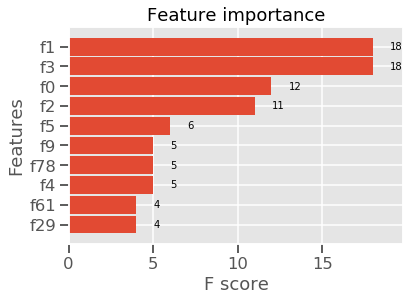

In [83]:
plot_importance(xgr, height=0.9, max_num_features=10)
plt.show()

In [84]:
svm = SVR(C=50, 
          epsilon=10**-7, 
          gamma="auto")
svm.fit(X_train_gap, g12m_train)
print("train", svm.score(X_train_gap, g12m_train))
print("test", svm.score(X_test_gap, g12m_test))

train 0.9998274211418227
test 0.07494834113512283


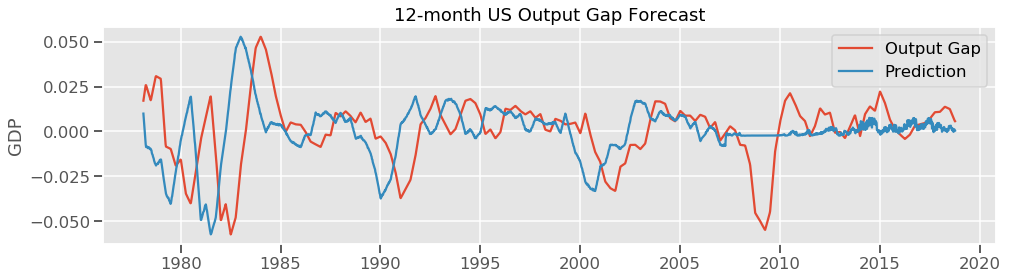

In [85]:
pred = pd.DataFrame(svm.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/12m_gap_svm")
plt.show()

In [86]:
# tscv = TimeSeriesSplit(n_splits=5)
# i = 1
# score_dict = {}
# for train_index, test_index in tscv.split(X_train):
#     X_tr, X_tst = X_train[train_index], X_train[test_index]
#     y_tr, y_tst = g12m_train[train_index], g12m_train[test_index]
#     score = 0
#     for mf in np.linspace(10, 100, 10):
#         for ne in np.linspace(10, 30, 11):
#             for md in np.linspace(5, 25, 11):
#                 for msl in np.linspace(10, 40, 16):
#                     rfr = RandomForestRegressor(max_features=int(mf),
#                                                 n_estimators=int(ne), 
#                                                 max_depth=int(md),
#                                                 min_samples_leaf=int(msl)
#                                                )
#                     rfr.fit(X_tr, y_tr)
#                     if score < rfr.score(X_tst, y_tst):
#                         score_dict[i] = [mf, ne, md, msl, rfr.score(X_tst, y_tst)]
#     i += 1

In [87]:
# score_dict

In [88]:
rfr = RandomForestRegressor(max_features=50,
                            n_estimators=50, 
                            max_depth=20, 
                            min_samples_leaf=30,
                            random_state=0
                           )
rfr.fit(X_train_gap, g12m_train)
print("train: ", rfr.score(X_train_gap, g12m_train))
print("test: ", rfr.score(X_test_gap, g12m_test))

train:  0.7503961897767589
test:  0.21730342507844091


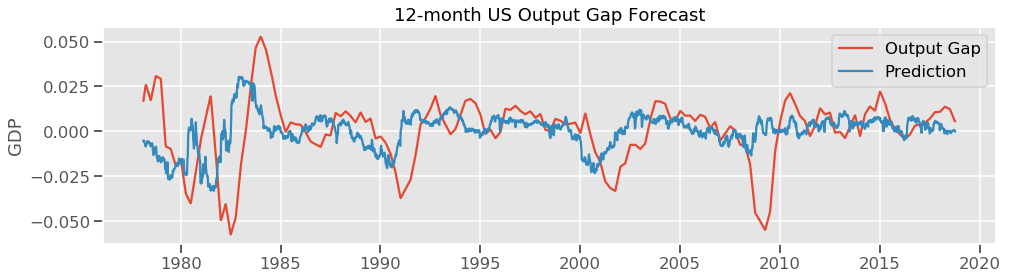

In [89]:
pred = pd.DataFrame(rfr.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/12m_gap_rfr")
plt.show()

In [90]:
xgr = XGBRegressor(max_depth=2, 
                   learning_rate=0.13, 
                   n_estimators=40)
xgr.fit(X_train_gap,
        g12m_train)
print("train", xgr.score(X_train_gap, g12m_train))
print("test", xgr.score(X_test_gap, g12m_test))

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[09:14:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train 0.7581930519298301
test 0.07293010866790584


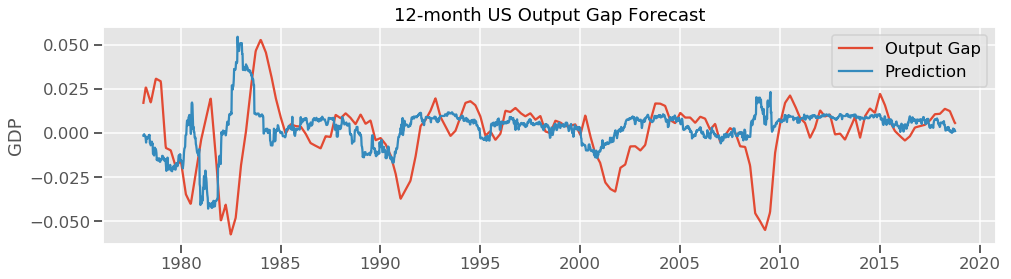

In [91]:
pred = pd.DataFrame(xgr.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/12m_gap_xgr")
plt.show()

In [34]:
X_rnn = pd.concat([week, 
               month, 
               three_m, 
               six_m, 
               one_y,
               df_merged[actual].fillna(method="ffill"),
               df_WILL5000_5d_vol,
               df_WILL5000_30d_vol
              ], axis=1)[52:]

In [35]:
X_gap = df_merged.gap[52:]

In [36]:
np.reshape(np.array(X_gap), (X_gap.shape[0], 1)).shape

(2175, 1)

In [37]:
scaler = StandardScaler()
X_scaled_rnn = pd.DataFrame(scaler.fit_transform(X_rnn))

In [38]:
pca_rnn = PCA()
X_pca_rnn = pca_rnn.fit_transform(X_scaled_rnn)

In [39]:
X_pca_gap_rnn = np.concatenate([np.reshape(np.array(X_gap), (X_gap.shape[0], 1)), X_pca_rnn], axis=1)

In [40]:
X_pca_gap_rnn.shape

(2175, 368)

In [41]:
n_pc = 30

In [42]:
X_train_non_gap_rnn = X_pca_rnn[:int(X_pca_rnn.shape[0]*0.7), :n_pc]
X_test_non_gap_rnn = X_pca_rnn[int(X_pca_rnn.shape[0]*0.7):, :n_pc]
X_train_gap_rnn = X_pca_gap_rnn[:int(X_pca_rnn.shape[0]*0.7), :n_pc]
X_test_gap_rnn = X_pca_gap_rnn[int(X_pca_rnn.shape[0]*0.7):, :n_pc]

In [43]:
X_train_gap_rnn.shape

(1522, 30)

In [44]:
# Creating a data structure with 52 timesteps and 1 output
X_train_g_rnn = []
y_train_g_rnn = []
for i in range(52, X_train_non_gap_rnn.shape[0]):
    X_train_g_rnn.append(X_train_gap_rnn[i-52:i, :])
    y_train_g_rnn.append(g6m_train[i])

X_train_g_rnn = np.array(X_train_g_rnn)
y_train_g_rnn = np.array(y_train_g_rnn)

# Reshaping
X_train_g_rnn = np.reshape(X_train_g_rnn, (X_train_g_rnn.shape[0], 
                                           X_train_g_rnn.shape[1],
                                           X_train_gap_rnn.shape[1]))

In [45]:
# Creating a data structure with 52 timesteps and 1 output
X_train_rnn = []
y_train_rnn = []
for i in range(52, X_train_non_gap_rnn.shape[0]):
    X_train_rnn.append(X_train_non_gap_rnn[i-52:i, :])
    y_train_rnn.append(g6m_train[i])

X_train_rnn = np.array(X_train_rnn)
y_train_rnn = np.array(y_train_rnn)

# Reshaping
X_train_rnn = np.reshape(X_train_rnn, (X_train_rnn.shape[0], X_train_rnn.shape[1], X_train_non_gap_rnn.shape[1]))

In [46]:
X_all_gap_rnn = X_pca_gap_rnn[:, :n_pc]

# Creating a data structure with 60 timesteps and 1 output
X_all_g_rnn = []

for i in range(52, X_all_gap_rnn.shape[0]):
    X_all_g_rnn.append(X_all_gap_rnn[i-52:i, :])


X_all_g_rnn = np.array(X_all_g_rnn)

# Reshaping
X_all_g_rnn = np.reshape(X_all_g_rnn, 
                           (X_all_g_rnn.shape[0],
                            X_all_g_rnn.shape[1],
                            X_all_gap_rnn.shape[1]))

In [47]:
X_all_non_gap_rnn = X_pca_rnn[:, :n_pc]

# Creating a data structure with 60 timesteps and 1 output
X_all_rnn = []

for i in range(52, X_all_non_gap_rnn.shape[0]):
    X_all_rnn.append(X_all_non_gap_rnn[i-52:i, :])


X_all_rnn = np.array(X_all_rnn)

# Reshaping
X_all_rnn = np.reshape(X_all_rnn, (X_all_rnn.shape[0], 
                                   X_all_rnn.shape[1], 
                                   X_all_non_gap_rnn.shape[1]))

In [48]:
print(X_train_g_rnn.shape)
print(y_train_g_rnn.shape)
print(X_all_g_rnn.shape)

(1470, 52, 30)
(1470,)
(2123, 52, 30)


In [63]:
drop_out = 0.5
prediction_list = []
for i in range (0,10):
    regressor = Sequential()

    regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
    regressor.add(Dropout(drop_out))

    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(drop_out))

    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(drop_out))
    
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(drop_out))

    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(drop_out))
    
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(drop_out))
    
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(drop_out))

    regressor.add(Dense(units=1))

    regressor.compile(optimizer='adam', loss='mean_squared_error')

    regressor.fit(X_train_g_rnn, 
                  y_train_g_rnn, 
                  epochs=50, 
                  batch_size=50)

    predicted = regressor.predict(X_all_g_rnn)
    pred = pd.DataFrame(predicted)
    pred.set_index(X.index[52:], inplace=True)
    pred.columns = [i]
    prediction_list.append(pred)
    print("--- {}% completed ---".format(i*10+10))

pred_gap_df = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), prediction_list)

Epoch 1/50
1470/1470 [==============================] - 25s 17ms/step - loss: 3.1557e-04
Epoch 2/50
1470/1470 [==============================] - 11s 8ms/step - loss: 1.0891e-04
Epoch 3/50
1470/1470 [==============================] - 12s 8ms/step - loss: 7.2252e-05
Epoch 4/50
1470/1470 [==============================] - 11s 8ms/step - loss: 6.8120e-05
Epoch 5/50
1470/1470 [==============================] - 11s 8ms/step - loss: 4.1695e-05
Epoch 6/50
1470/1470 [==============================] - 11s 8ms/step - loss: 4.0986e-05
Epoch 7/50
1470/1470 [==============================] - 11s 8ms/step - loss: 4.1487e-05
Epoch 8/50
1470/1470 [==============================] - 11s 8ms/step - loss: 4.7331e-05
Epoch 9/50
1470/1470 [==============================] - 11s 8ms/step - loss: 4.4374e-05
Epoch 10/50
1470/1470 [==============================] - 11s 7ms/step - loss: 3.5496e-05
Epoch 11/50
1470/1470 [==============================] - 11s 8ms/step - loss: 3.5211e-05
Epoch 12/50
1470/1470 [======

Epoch 43/50
1470/1470 [==============================] - 11s 8ms/step - loss: 1.7067e-05
Epoch 44/50
1470/1470 [==============================] - 11s 7ms/step - loss: 1.7133e-05
Epoch 45/50
1470/1470 [==============================] - 11s 8ms/step - loss: 1.9463e-05
Epoch 46/50
1470/1470 [==============================] - 11s 8ms/step - loss: 1.8064e-05
Epoch 47/50
1470/1470 [==============================] - 11s 7ms/step - loss: 1.7024e-05
Epoch 48/50
1470/1470 [==============================] - 11s 7ms/step - loss: 1.7699e-05
Epoch 49/50
1470/1470 [==============================] - 11s 8ms/step - loss: 1.7180e-05
Epoch 50/50
1470/1470 [==============================] - 11s 8ms/step - loss: 1.4298e-05
--- 20% completed ---
Epoch 1/50
1470/1470 [==============================] - 26s 18ms/step - loss: 3.3848e-04
Epoch 2/50
1470/1470 [==============================] - 11s 8ms/step - loss: 1.0158e-04
Epoch 3/50
1470/1470 [==============================] - 11s 8ms/step - loss: 8.0426e-05
E

1470/1470 [==============================] - 11s 7ms/step - loss: 2.1888e-05
Epoch 26/50
1470/1470 [==============================] - 11s 7ms/step - loss: 2.0101e-05
Epoch 27/50
1470/1470 [==============================] - 11s 7ms/step - loss: 2.5550e-05
Epoch 28/50
1470/1470 [==============================] - 11s 7ms/step - loss: 2.2452e-05
Epoch 29/50
1470/1470 [==============================] - 11s 7ms/step - loss: 2.1957e-05
Epoch 30/50
1470/1470 [==============================] - 11s 8ms/step - loss: 2.4197e-05
Epoch 31/50
1470/1470 [==============================] - 11s 7ms/step - loss: 2.2197e-05
Epoch 32/50
1470/1470 [==============================] - 11s 7ms/step - loss: 2.0308e-05
Epoch 33/50
1470/1470 [==============================] - 11s 7ms/step - loss: 2.0881e-05
Epoch 34/50
1470/1470 [==============================] - 11s 7ms/step - loss: 1.7108e-05
Epoch 35/50
1470/1470 [==============================] - 12s 8ms/step - loss: 1.9392e-05
Epoch 36/50
1470/1470 [==========

1470/1470 [==============================] - 11s 8ms/step - loss: 4.6129e-05
Epoch 8/50
1470/1470 [==============================] - 11s 7ms/step - loss: 4.5617e-05
Epoch 9/50
1470/1470 [==============================] - 11s 8ms/step - loss: 4.0847e-05
Epoch 10/50
1470/1470 [==============================] - 11s 8ms/step - loss: 3.5026e-05
Epoch 11/50
1470/1470 [==============================] - 11s 8ms/step - loss: 3.1246e-05
Epoch 12/50
1470/1470 [==============================] - 13s 9ms/step - loss: 3.3884e-05
Epoch 13/50
1470/1470 [==============================] - 11s 8ms/step - loss: 3.0356e-05
Epoch 14/50
1470/1470 [==============================] - 12s 8ms/step - loss: 3.1429e-05
Epoch 15/50
1470/1470 [==============================] - 11s 8ms/step - loss: 2.8742e-05
Epoch 16/50
1470/1470 [==============================] - 11s 8ms/step - loss: 3.2639e-05
Epoch 17/50
1470/1470 [==============================] - 11s 8ms/step - loss: 3.1102e-05
Epoch 18/50
1470/1470 [============

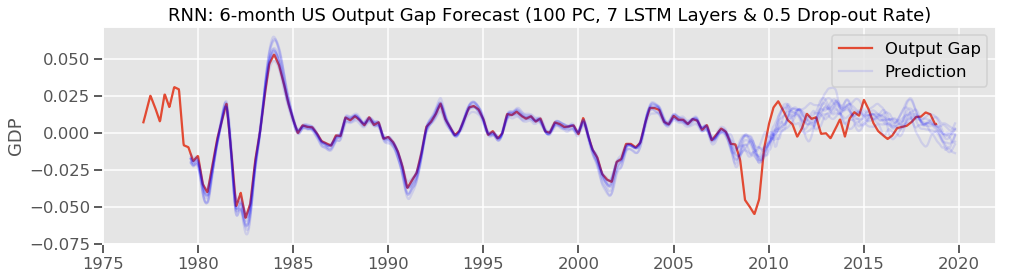

In [87]:
fig = plt.figure(figsize=(16,4))
pred_each = pd.DataFrame(pred_gap_df.shift(26))
ax = plt.plot(df_merged.gap[X_scaled.index])
ax = plt.plot(pred_each, c="blue", alpha = 0.1)
plt.title("RNN: 6-month US Output Gap Forecast (100 PC, 7 LSTM Layers & 0.5 Drop-out Rate)")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/6m_gap_rnn_7_LSTM_0.7_dropout_100_pca.png")
plt.show()

pred_each.to_csv("../data/7_LSTM_0.5_DO_100pc_result.csv")

In [49]:
prediction_dict_gap = {}
for i in [2, 4, 6, 8]:
    drop_out = i / 10

    prediction_list = []
    for i in range (0,10):
        regressor = Sequential()

        regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
        regressor.add(Dropout(drop_out))

        regressor.add(LSTM(units=50, return_sequences=True))
        regressor.add(Dropout(drop_out))

        regressor.add(LSTM(units=50, return_sequences=True))
        regressor.add(Dropout(drop_out))

        regressor.add(LSTM(units=50, return_sequences=True))
        regressor.add(Dropout(drop_out))

        regressor.add(LSTM(units=50, return_sequences=True))
        regressor.add(Dropout(drop_out))

        regressor.add(LSTM(units=50, return_sequences=True))
        regressor.add(Dropout(drop_out))

        regressor.add(LSTM(units=50))
        regressor.add(Dropout(drop_out))

        regressor.add(Dense(units=1))

        regressor.compile(optimizer='adam', loss='mean_squared_error')

        regressor.fit(X_train_g_rnn, 
                      y_train_g_rnn, 
                      epochs=40, 
                      batch_size=50)

        predicted = regressor.predict(X_all_g_rnn)
        pred = pd.DataFrame(predicted)
        pred.set_index(X.index[52:], inplace=True)
        pred.columns = [i]
        prediction_list.append(pred)
        print("---Drop out {}: {}% completed---".format(drop_out, i*10+10))
    prediction_dict_gap[drop_out] = prediction_list

W1021 11:24:56.811191 140735636788096 deprecation_wrapper.py:119] From /Users/kmiyaki/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1021 11:24:56.838495 140735636788096 deprecation_wrapper.py:119] From /Users/kmiyaki/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1021 11:24:56.844016 140735636788096 deprecation_wrapper.py:119] From /Users/kmiyaki/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1021 11:24:57.098537 140735636788096 deprecation_wrapper.py:119] From /Users/kmiyaki/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.p

Epoch 1/40
1470/1470 [==============================] - 17s 11ms/step - loss: 1.6509e-04
Epoch 2/40
1470/1470 [==============================] - 11s 7ms/step - loss: 3.8943e-05
Epoch 3/40
1470/1470 [==============================] - 11s 7ms/step - loss: 2.1287e-05
Epoch 4/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.9182e-05
Epoch 5/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.6070e-05
Epoch 6/40
1470/1470 [==============================] - 10s 7ms/step - loss: 1.5152e-05
Epoch 7/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.3003e-05
Epoch 8/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.3686e-05
Epoch 9/40
1470/1470 [==============================] - 10s 7ms/step - loss: 1.9946e-05
Epoch 10/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.4355e-05
Epoch 11/40
1470/1470 [==============================] - 10s 7ms/step - loss: 1.3092e-05
Epoch 12/40
1470/1470 [======

1470/1470 [==============================] - 11s 7ms/step - loss: 1.3011e-05
Epoch 13/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.1148e-05
Epoch 14/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.1446e-05
Epoch 15/40
1470/1470 [==============================] - 10s 7ms/step - loss: 1.1083e-05
Epoch 16/40
1470/1470 [==============================] - 11s 7ms/step - loss: 9.1963e-06
Epoch 17/40
1470/1470 [==============================] - 11s 7ms/step - loss: 9.4033e-06
Epoch 18/40
1470/1470 [==============================] - 11s 7ms/step - loss: 7.5477e-06
Epoch 19/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.0004e-05
Epoch 20/40
1470/1470 [==============================] - 11s 7ms/step - loss: 8.1414e-06
Epoch 21/40
1470/1470 [==============================] - 11s 7ms/step - loss: 9.3132e-06
Epoch 22/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.0297e-05
Epoch 23/40
1470/1470 [==========

1470/1470 [==============================] - 11s 7ms/step - loss: 8.9163e-06
Epoch 24/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.2177e-05
Epoch 25/40
1470/1470 [==============================] - 11s 8ms/step - loss: 8.6641e-06
Epoch 26/40
1470/1470 [==============================] - 11s 8ms/step - loss: 9.6358e-06
Epoch 27/40
1470/1470 [==============================] - 12s 8ms/step - loss: 7.9295e-06
Epoch 28/40
1470/1470 [==============================] - 11s 7ms/step - loss: 8.3761e-06
Epoch 29/40
1470/1470 [==============================] - 11s 8ms/step - loss: 9.6023e-06
Epoch 30/40
1470/1470 [==============================] - 11s 8ms/step - loss: 8.1184e-06
Epoch 31/40
1470/1470 [==============================] - 11s 8ms/step - loss: 8.0699e-06
Epoch 32/40
1470/1470 [==============================] - 11s 8ms/step - loss: 7.3883e-06
Epoch 33/40
1470/1470 [==============================] - 11s 8ms/step - loss: 7.9541e-06
Epoch 34/40
1470/1470 [==========

1470/1470 [==============================] - 11s 7ms/step - loss: 8.2321e-06
Epoch 35/40
1470/1470 [==============================] - 11s 8ms/step - loss: 9.4722e-06
Epoch 36/40
1470/1470 [==============================] - 11s 8ms/step - loss: 6.9497e-06
Epoch 37/40
1470/1470 [==============================] - 11s 8ms/step - loss: 7.6597e-06
Epoch 38/40
1470/1470 [==============================] - 11s 7ms/step - loss: 7.0447e-06
Epoch 39/40
1470/1470 [==============================] - 11s 7ms/step - loss: 7.8093e-06
Epoch 40/40
1470/1470 [==============================] - 11s 8ms/step - loss: 7.3866e-06
---Drop out 0.2: 70% completed---
Epoch 1/40
1470/1470 [==============================] - 21s 14ms/step - loss: 2.1032e-04
Epoch 2/40
1470/1470 [==============================] - 11s 7ms/step - loss: 4.4400e-05
Epoch 3/40
1470/1470 [==============================] - 11s 8ms/step - loss: 2.4687e-05
Epoch 4/40
1470/1470 [==============================] - 11s 8ms/step - loss: 2.1505e-05
Ep

1470/1470 [==============================] - 11s 7ms/step - loss: 1.6455e-05
Epoch 6/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.7571e-05
Epoch 7/40
1470/1470 [==============================] - 11s 8ms/step - loss: 1.4902e-05
Epoch 8/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.3646e-05
Epoch 9/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.2730e-05
Epoch 10/40
1470/1470 [==============================] - 11s 8ms/step - loss: 1.1701e-05
Epoch 11/40
1470/1470 [==============================] - 11s 8ms/step - loss: 1.4173e-05
Epoch 12/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.1879e-05
Epoch 13/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.1993e-05
Epoch 14/40
1470/1470 [==============================] - 11s 8ms/step - loss: 9.5575e-06
Epoch 15/40
1470/1470 [==============================] - 11s 8ms/step - loss: 1.1941e-05
Epoch 16/40
1470/1470 [==============

1470/1470 [==============================] - 12s 8ms/step - loss: 1.9184e-05
Epoch 17/40
1470/1470 [==============================] - 12s 8ms/step - loss: 1.8982e-05
Epoch 18/40
1470/1470 [==============================] - 11s 8ms/step - loss: 1.9456e-05
Epoch 19/40
1470/1470 [==============================] - 11s 8ms/step - loss: 1.8964e-05
Epoch 20/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.9475e-05
Epoch 21/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.7653e-05
Epoch 22/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.8389e-05
Epoch 23/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.5138e-05
Epoch 24/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.7977e-05
Epoch 25/40
1470/1470 [==============================] - 12s 8ms/step - loss: 1.5839e-05
Epoch 26/40
1470/1470 [==============================] - 11s 8ms/step - loss: 1.8413e-05
Epoch 27/40
1470/1470 [==========

1470/1470 [==============================] - 14s 9ms/step - loss: 1.6016e-05
Epoch 28/40
1470/1470 [==============================] - 12s 8ms/step - loss: 1.6891e-05
Epoch 29/40
1470/1470 [==============================] - 15s 10ms/step - loss: 1.5528e-05
Epoch 30/40
1470/1470 [==============================] - 14s 10ms/step - loss: 1.6349e-05
Epoch 31/40
1470/1470 [==============================] - 15s 10ms/step - loss: 1.7138e-05
Epoch 32/40
1470/1470 [==============================] - 15s 10ms/step - loss: 1.4415e-05
Epoch 33/40
1470/1470 [==============================] - 12s 8ms/step - loss: 1.4078e-05
Epoch 34/40
1470/1470 [==============================] - 14s 9ms/step - loss: 1.5406e-05
Epoch 35/40
1470/1470 [==============================] - 14s 9ms/step - loss: 1.3312e-05
Epoch 36/40
1470/1470 [==============================] - 16s 11ms/step - loss: 1.1652e-05
Epoch 37/40
1470/1470 [==============================] - 14s 9ms/step - loss: 1.3721e-05
Epoch 38/40
1470/1470 [=====

1470/1470 [==============================] - 12s 8ms/step - loss: 1.4865e-05
Epoch 39/40
1470/1470 [==============================] - 12s 8ms/step - loss: 1.3314e-05
Epoch 40/40
1470/1470 [==============================] - 12s 8ms/step - loss: 1.3597e-05
---Drop out 0.4: 60% completed---
Epoch 1/40
1470/1470 [==============================] - 30s 21ms/step - loss: 2.9702e-04
Epoch 2/40
1470/1470 [==============================] - 12s 8ms/step - loss: 9.1627e-05
Epoch 3/40
1470/1470 [==============================] - 12s 8ms/step - loss: 5.5105e-05
Epoch 4/40
1470/1470 [==============================] - 13s 9ms/step - loss: 5.1464e-05
Epoch 5/40
1470/1470 [==============================] - 12s 8ms/step - loss: 3.6675e-05
Epoch 6/40
1470/1470 [==============================] - 11s 8ms/step - loss: 3.5629e-05
Epoch 7/40
1470/1470 [==============================] - 14s 10ms/step - loss: 2.9965e-05
Epoch 8/40
1470/1470 [==============================] - 14s 9ms/step - loss: 2.9717e-05
Epoch

1470/1470 [==============================] - 11s 7ms/step - loss: 2.8276e-05
Epoch 10/40
1470/1470 [==============================] - 11s 8ms/step - loss: 2.6150e-05
Epoch 11/40
1470/1470 [==============================] - 15s 10ms/step - loss: 2.2360e-05
Epoch 12/40
1470/1470 [==============================] - 11s 8ms/step - loss: 2.3436e-05
Epoch 13/40
1470/1470 [==============================] - 12s 8ms/step - loss: 2.4647e-05
Epoch 14/40
1470/1470 [==============================] - 11s 7ms/step - loss: 2.6768e-05
Epoch 15/40
1470/1470 [==============================] - 11s 8ms/step - loss: 2.0559e-05
Epoch 16/40
1470/1470 [==============================] - 11s 7ms/step - loss: 2.1653e-05
Epoch 17/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.7697e-05
Epoch 18/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.9376e-05
Epoch 19/40
1470/1470 [==============================] - 11s 7ms/step - loss: 2.0140e-05
Epoch 20/40
1470/1470 [=========

W1021 14:05:05.688832 140735636788096 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1021 14:05:05.886111 140735636788096 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1021 14:05:06.093909 140735636788096 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1021 14:05:06.302960 140735636788096 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1021 14:05:06.520143 140735636788096 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Epoch 1/40
1470/1470 [==============================] - 32s 22ms/step - loss: 4.2110e-04
Epoch 2/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.8110e-04
Epoch 3/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.1763e-04
Epoch 4/40
1470/1470 [==============================] - 11s 7ms/step - loss: 9.9161e-05
Epoch 5/40
1470/1470 [==============================] - 11s 7ms/step - loss: 9.6366e-05
Epoch 6/40
1470/1470 [==============================] - 11s 8ms/step - loss: 7.2701e-05
Epoch 7/40
1470/1470 [==============================] - 11s 7ms/step - loss: 6.9004e-05
Epoch 8/40
1470/1470 [==============================] - 11s 8ms/step - loss: 6.2436e-05
Epoch 9/40
1470/1470 [==============================] - 11s 8ms/step - loss: 5.0789e-05
Epoch 10/40
1470/1470 [==============================] - 11s 8ms/step - loss: 4.7497e-05
Epoch 11/40
1470/1470 [==============================] - 12s 8ms/step - loss: 4.6442e-05
Epoch 12/40
1470/1470 [======

1470/1470 [==============================] - 11s 7ms/step - loss: 4.7408e-05
Epoch 13/40
1470/1470 [==============================] - 12s 8ms/step - loss: 4.6517e-05
Epoch 14/40
1470/1470 [==============================] - 11s 7ms/step - loss: 4.4214e-05
Epoch 15/40
1470/1470 [==============================] - 11s 7ms/step - loss: 4.1142e-05
Epoch 16/40
1470/1470 [==============================] - 11s 7ms/step - loss: 4.2182e-05
Epoch 17/40
1470/1470 [==============================] - 11s 8ms/step - loss: 3.9082e-05
Epoch 18/40
1470/1470 [==============================] - 12s 8ms/step - loss: 3.8091e-05
Epoch 19/40
1470/1470 [==============================] - 11s 7ms/step - loss: 3.7735e-05
Epoch 20/40
1470/1470 [==============================] - 11s 7ms/step - loss: 3.5534e-05
Epoch 21/40
1470/1470 [==============================] - 11s 7ms/step - loss: 3.1503e-05
Epoch 22/40
1470/1470 [==============================] - 11s 7ms/step - loss: 3.4463e-05
Epoch 23/40
1470/1470 [==========

1470/1470 [==============================] - 13s 9ms/step - loss: 3.0415e-05
Epoch 24/40
1470/1470 [==============================] - 12s 8ms/step - loss: 3.0040e-05
Epoch 25/40
1470/1470 [==============================] - 11s 7ms/step - loss: 3.2951e-05
Epoch 26/40
1470/1470 [==============================] - 11s 8ms/step - loss: 3.0665e-05
Epoch 27/40
1470/1470 [==============================] - 12s 8ms/step - loss: 3.0275e-05
Epoch 28/40
1470/1470 [==============================] - 11s 8ms/step - loss: 3.4010e-05
Epoch 29/40
1470/1470 [==============================] - 11s 8ms/step - loss: 3.2073e-05
Epoch 30/40
1470/1470 [==============================] - 11s 7ms/step - loss: 2.7832e-05
Epoch 31/40
1470/1470 [==============================] - 11s 8ms/step - loss: 2.4317e-05
Epoch 32/40
1470/1470 [==============================] - 14s 9ms/step - loss: 2.7839e-05
Epoch 33/40
1470/1470 [==============================] - 16s 11ms/step - loss: 2.7252e-05
Epoch 34/40
1470/1470 [=========

1470/1470 [==============================] - 11s 8ms/step - loss: 3.2444e-05
Epoch 35/40
1470/1470 [==============================] - 11s 8ms/step - loss: 2.9307e-05
Epoch 36/40
1470/1470 [==============================] - 11s 7ms/step - loss: 3.1908e-05
Epoch 37/40
1470/1470 [==============================] - 11s 8ms/step - loss: 2.8376e-05
Epoch 38/40
1470/1470 [==============================] - 11s 8ms/step - loss: 2.9073e-05
Epoch 39/40
1470/1470 [==============================] - 12s 8ms/step - loss: 2.8917e-05
Epoch 40/40
1470/1470 [==============================] - 12s 8ms/step - loss: 2.6409e-05
---Drop out 0.6: 70% completed---
Epoch 1/40
1470/1470 [==============================] - 38s 26ms/step - loss: 4.5673e-04
Epoch 2/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.8591e-04
Epoch 3/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.3243e-04
Epoch 4/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.0219e-04
Ep

1470/1470 [==============================] - 11s 7ms/step - loss: 8.8914e-05
Epoch 6/40
1470/1470 [==============================] - 11s 7ms/step - loss: 6.9065e-05
Epoch 7/40
1470/1470 [==============================] - 11s 8ms/step - loss: 6.3528e-05
Epoch 8/40
1470/1470 [==============================] - 11s 8ms/step - loss: 6.6988e-05
Epoch 9/40
1470/1470 [==============================] - 11s 8ms/step - loss: 5.7994e-05
Epoch 10/40
1470/1470 [==============================] - 11s 8ms/step - loss: 6.1565e-05
Epoch 11/40
1470/1470 [==============================] - 14s 9ms/step - loss: 4.8441e-05
Epoch 12/40
1470/1470 [==============================] - 12s 8ms/step - loss: 4.8177e-05
Epoch 13/40
1470/1470 [==============================] - 11s 8ms/step - loss: 4.1031e-05
Epoch 14/40
1470/1470 [==============================] - 12s 8ms/step - loss: 3.8947e-05
Epoch 15/40
1470/1470 [==============================] - 12s 8ms/step - loss: 4.1808e-05
Epoch 16/40
1470/1470 [==============

1470/1470 [==============================] - 12s 8ms/step - loss: 1.6006e-04
Epoch 17/40
1470/1470 [==============================] - 11s 8ms/step - loss: 1.5329e-04
Epoch 18/40
1470/1470 [==============================] - 12s 8ms/step - loss: 1.5060e-04
Epoch 19/40
1470/1470 [==============================] - 12s 8ms/step - loss: 1.3136e-04
Epoch 20/40
1470/1470 [==============================] - 11s 8ms/step - loss: 1.2245e-04
Epoch 21/40
1470/1470 [==============================] - 11s 8ms/step - loss: 1.3296e-04
Epoch 22/40
1470/1470 [==============================] - 12s 8ms/step - loss: 1.2216e-04
Epoch 23/40
1470/1470 [==============================] - 11s 8ms/step - loss: 1.0974e-04
Epoch 24/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.0392e-04
Epoch 25/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.1613e-04
Epoch 26/40
1470/1470 [==============================] - 11s 7ms/step - loss: 1.0787e-04
Epoch 27/40
1470/1470 [==========

1470/1470 [==============================] - 11s 7ms/step - loss: 9.5376e-05
Epoch 28/40
1470/1470 [==============================] - 11s 7ms/step - loss: 9.8562e-05
Epoch 29/40
1470/1470 [==============================] - 11s 7ms/step - loss: 9.3689e-05
Epoch 30/40
1470/1470 [==============================] - 11s 7ms/step - loss: 9.2436e-05
Epoch 31/40
1470/1470 [==============================] - 11s 7ms/step - loss: 8.7255e-05
Epoch 32/40
1470/1470 [==============================] - 11s 7ms/step - loss: 9.1470e-05
Epoch 33/40
1470/1470 [==============================] - 11s 7ms/step - loss: 8.5045e-05
Epoch 34/40
1470/1470 [==============================] - 11s 7ms/step - loss: 8.1814e-05
Epoch 35/40
1470/1470 [==============================] - 11s 7ms/step - loss: 8.1505e-05
Epoch 36/40
1470/1470 [==============================] - 11s 7ms/step - loss: 9.4604e-05
Epoch 37/40
1470/1470 [==============================] - 11s 7ms/step - loss: 7.6262e-05
Epoch 38/40
1470/1470 [==========

1470/1470 [==============================] - 11s 7ms/step - loss: 7.9349e-05
Epoch 39/40
1470/1470 [==============================] - 11s 7ms/step - loss: 7.1599e-05
Epoch 40/40
1470/1470 [==============================] - 11s 7ms/step - loss: 7.5227e-05
---Drop out 0.8: 60% completed---
Epoch 1/40
1470/1470 [==============================] - 44s 30ms/step - loss: 0.0026
Epoch 2/40
1470/1470 [==============================] - 11s 7ms/step - loss: 9.8919e-04
Epoch 3/40
1470/1470 [==============================] - 11s 7ms/step - loss: 6.9802e-04
Epoch 4/40
1470/1470 [==============================] - 11s 7ms/step - loss: 5.3388e-04
Epoch 5/40
1470/1470 [==============================] - 11s 7ms/step - loss: 4.8879e-04
Epoch 6/40
1470/1470 [==============================] - 11s 7ms/step - loss: 4.2965e-04
Epoch 7/40
1470/1470 [==============================] - 11s 7ms/step - loss: 3.6731e-04
Epoch 8/40
1470/1470 [==============================] - 10s 7ms/step - loss: 3.1627e-04
Epoch 9/40

1470/1470 [==============================] - 12s 8ms/step - loss: 2.6629e-04
Epoch 10/40
1470/1470 [==============================] - 12s 8ms/step - loss: 2.6945e-04
Epoch 11/40
1470/1470 [==============================] - 11s 8ms/step - loss: 2.3658e-04
Epoch 12/40
1470/1470 [==============================] - 11s 7ms/step - loss: 2.1551e-04
Epoch 13/40
1470/1470 [==============================] - 11s 8ms/step - loss: 1.9353e-04
Epoch 14/40
1470/1470 [==============================] - 11s 8ms/step - loss: 1.6925e-04
Epoch 15/40
1470/1470 [==============================] - 11s 8ms/step - loss: 1.6742e-04
Epoch 16/40
1470/1470 [==============================] - 13s 9ms/step - loss: 1.5997e-04
Epoch 17/40
1470/1470 [==============================] - 17s 11ms/step - loss: 1.4817e-04
Epoch 18/40
1470/1470 [==============================] - 12s 8ms/step - loss: 1.3138e-04
Epoch 19/40
1470/1470 [==============================] - 12s 8ms/step - loss: 1.3043e-04
Epoch 20/40
1470/1470 [=========

In [50]:
pred_gap_df_dict = {}
for key in prediction_dict_gap.keys():
    pred_gap_df_dict[key] = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), prediction_dict_gap[key])

In [86]:
for i in [0.1, 0.3, 0.5, 0.7, 0.9]:
    pred_gap_df_dict[i] = pd.read_csv("../data/7_LSTM_{}_DO.csv".format(i), 
                                      index_col="date",
                                      parse_dates=["date"],
                                     ).shift(-26).rename(columns={"0":0,
                                                                  "1":1,
                                                                  "2":2,
                                                                  "3":3,
                                                                  "4":4,
                                                                  "5":5,
                                                                  "6":6,
                                                                  "7":7,
                                                                  "8":8,
                                                                  "9":9
        
    })

In [87]:
pred_gap_df_dict.keys()

dict_keys([0.2, 0.4, 0.6, 0.8, 0.1, 0.3, 0.5, 0.7, 0.9])

In [88]:
pred_gap_df_dict[0.2].head()

0         1         2         3         4         5  \
date                                                                     
1979-02-18 -0.013363 -0.014782 -0.016420 -0.017419 -0.018002 -0.016599   
1979-02-25 -0.013974 -0.015415 -0.017006 -0.018065 -0.018945 -0.017292   
1979-03-04 -0.014536 -0.016113 -0.017551 -0.018828 -0.019794 -0.018102   
1979-03-11 -0.015021 -0.016907 -0.018049 -0.019606 -0.020433 -0.019095   
1979-03-18 -0.015405 -0.017710 -0.018464 -0.020329 -0.020721 -0.020097   

                   6         7         8         9  
date                                                
1979-02-18 -0.012721 -0.013346 -0.016359 -0.018547  
1979-02-25 -0.013554 -0.013937 -0.016965 -0.019092  
1979-03-04 -0.014277 -0.014498 -0.017509 -0.019625  
1979-03-11 -0.014865 -0.015000 -0.017967 -0.020106  
1979-03-18 -0.015313 -0.015396 -0.018328 -0.020503

In [76]:
pred_gap_df_dict[0.1].index

DatetimeIndex(['1979-02-18', '1979-02-25', '1979-03-04', '1979-03-11',
               '1979-03-18', '1979-03-25', '1979-04-01', '1979-04-08',
               '1979-04-15', '1979-04-22',
               ...
               '2019-08-18', '2019-08-25', '2019-09-01', '2019-09-08',
               '2019-09-15', '2019-09-22', '2019-09-29', '2019-10-06',
               '2019-10-13', '2019-10-20'],
              dtype='datetime64[ns]', name='date', length=2123, freq=None)

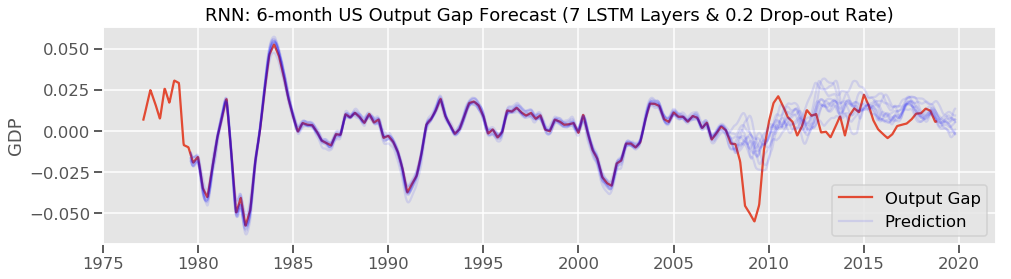

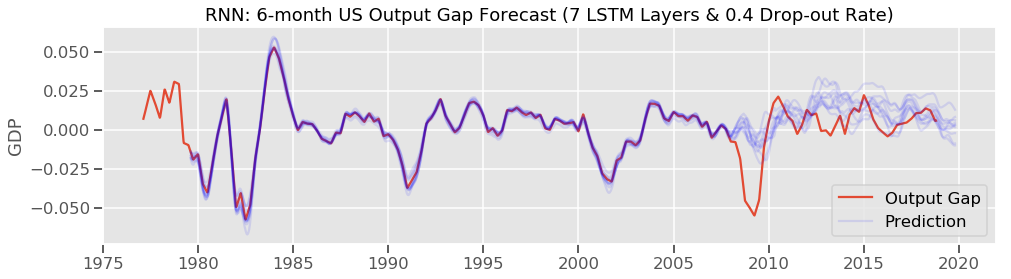

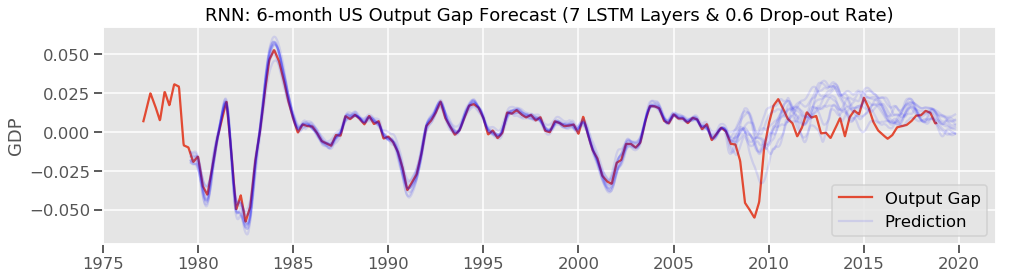

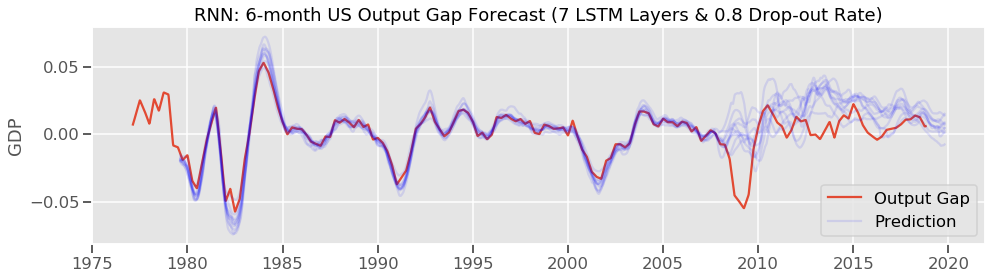

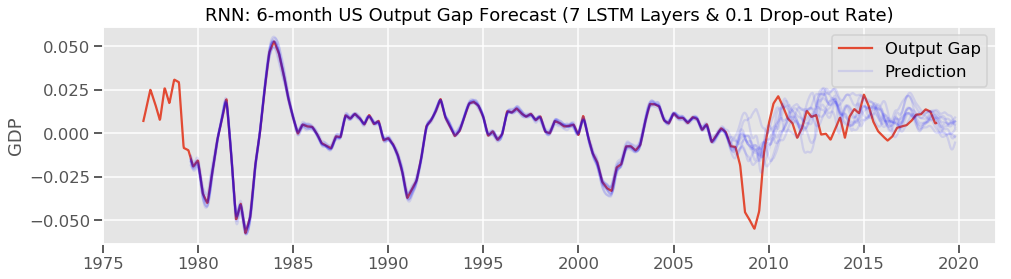

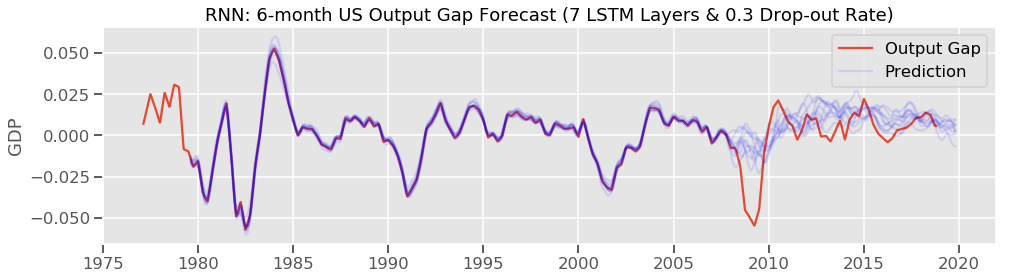

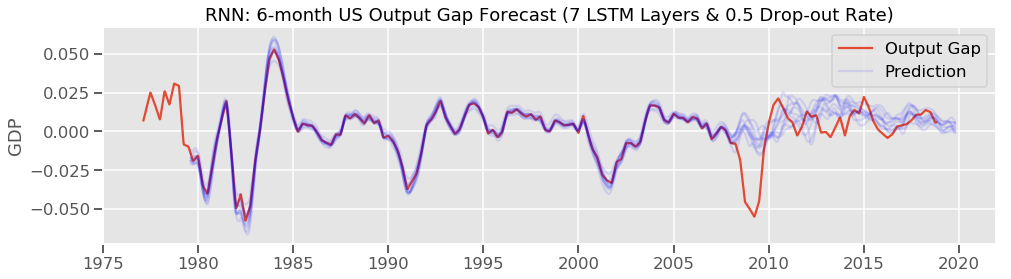

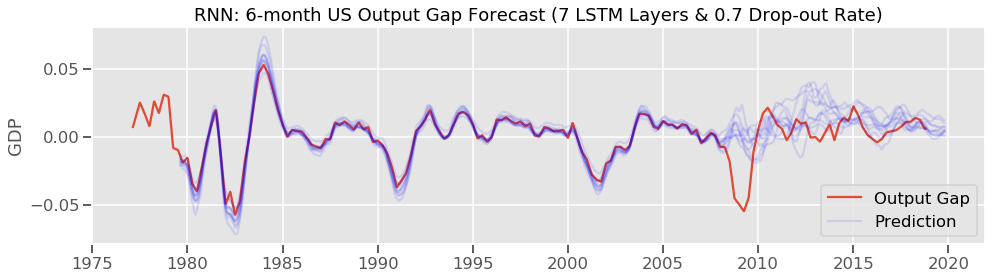

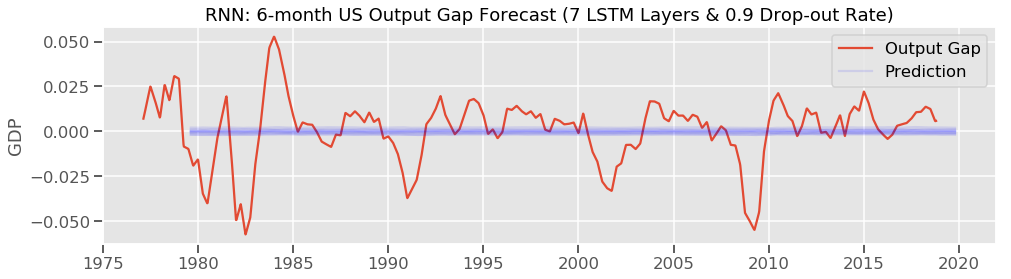

In [77]:
for key in pred_gap_df_dict.keys():
    fig = plt.figure(figsize=(16,4))
    pred_each = pd.DataFrame(pred_gap_df_dict[key].shift(26))
    ax = plt.plot(df_merged.gap[X_scaled.index])
    ax = plt.plot(pred_each, c="blue", alpha = 0.1)
    plt.title("RNN: 6-month US Output Gap Forecast (7 LSTM Layers & {} Drop-out Rate)".format(key))
    plt.ylabel("GDP")
    plt.legend(["Output Gap", "Prediction"])
#     plt.savefig("../images/6m_gap_rnn_7_LSTM_dropout_{}.png".format(key))
    plt.show()
#     pred_each.to_csv("../data/7_LSTM_{}_DO.csv".format(key))

In [102]:
# prediction_dict_gap_layer = {}
for i in range(6,8):
    drop_out = 0.5

    prediction_list = []
    for k in range (0,10):
        regressor = Sequential()

        regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
        regressor.add(Dropout(drop_out))

        j = i
        while j > 0:
    
            regressor.add(LSTM(units=50, return_sequences=True))
            regressor.add(Dropout(drop_out))

            j -= 1

        regressor.add(LSTM(units=50))
        regressor.add(Dropout(drop_out))

        regressor.add(Dense(units=1))

        regressor.compile(optimizer='adam', loss='mean_squared_error')

        regressor.fit(X_train_g_rnn, 
                      y_train_g_rnn, 
                      epochs=40, 
                      batch_size=50)

        predicted = regressor.predict(X_all_g_rnn)
        pred = pd.DataFrame(predicted)
        pred.set_index(X.index[52:], inplace=True)
        pred.columns = [k]
        prediction_list.append(pred)
        print("---Layer {}: {}% completed---".format(i+2, k*10+10))
    prediction_dict_gap_layer[i] = prediction_list

Epoch 1/40
1470/1470 [==============================] - 184s 125ms/step - loss: 2.8105e-04
Epoch 2/40
1470/1470 [==============================] - 14s 10ms/step - loss: 1.0329e-04
Epoch 3/40
1470/1470 [==============================] - 14s 9ms/step - loss: 6.7677e-05
Epoch 4/40
1470/1470 [==============================] - 13s 9ms/step - loss: 6.2471e-05
Epoch 5/40
1470/1470 [==============================] - 13s 9ms/step - loss: 4.3800e-05
Epoch 6/40
1470/1470 [==============================] - 14s 9ms/step - loss: 4.5746e-05
Epoch 7/40
1470/1470 [==============================] - 14s 9ms/step - loss: 3.8402e-05
Epoch 8/40
1470/1470 [==============================] - 13s 9ms/step - loss: 4.3867e-05
Epoch 9/40
1470/1470 [==============================] - 13s 9ms/step - loss: 4.2924e-05
Epoch 10/40
1470/1470 [==============================] - 13s 9ms/step - loss: 3.3440e-05
Epoch 11/40
1470/1470 [==============================] - 13s 9ms/step - loss: 3.1445e-05
Epoch 12/40
1470/1470 [===

1470/1470 [==============================] - 13s 9ms/step - loss: 2.6904e-05
Epoch 24/40
1470/1470 [==============================] - 13s 9ms/step - loss: 2.4143e-05
Epoch 25/40
1470/1470 [==============================] - 13s 9ms/step - loss: 1.9335e-05
Epoch 26/40
1470/1470 [==============================] - 14s 10ms/step - loss: 1.6135e-05
Epoch 27/40
1470/1470 [==============================] - 13s 9ms/step - loss: 2.1221e-05
Epoch 28/40
1470/1470 [==============================] - 13s 9ms/step - loss: 2.2902e-05
Epoch 29/40
1470/1470 [==============================] - 13s 9ms/step - loss: 2.1145e-05
Epoch 30/40
1470/1470 [==============================] - 13s 9ms/step - loss: 2.1677e-05
Epoch 31/40
1470/1470 [==============================] - 15s 10ms/step - loss: 2.1556e-05
Epoch 32/40
1470/1470 [==============================] - 14s 10ms/step - loss: 2.3392e-05
Epoch 33/40
1470/1470 [==============================] - 14s 10ms/step - loss: 2.0845e-05
Epoch 34/40
1470/1470 [======

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.568332). Check your callbacks.
  % delta_t_median)


1470/1470 [==============================] - 20s 13ms/step - loss: 3.3271e-05
Epoch 12/40
1470/1470 [==============================] - 13s 9ms/step - loss: 3.0131e-05
Epoch 13/40
1470/1470 [==============================] - 14s 9ms/step - loss: 3.1432e-05
Epoch 14/40
1470/1470 [==============================] - 13s 9ms/step - loss: 3.0737e-05
Epoch 15/40
1470/1470 [==============================] - 13s 9ms/step - loss: 2.6466e-05
Epoch 16/40
1470/1470 [==============================] - 13s 9ms/step - loss: 2.5841e-05
Epoch 17/40
1470/1470 [==============================] - 13s 9ms/step - loss: 2.2831e-05
Epoch 18/40
1470/1470 [==============================] - 13s 9ms/step - loss: 2.5840e-05
Epoch 19/40
1470/1470 [==============================] - 13s 9ms/step - loss: 2.7241e-05
Epoch 20/40
1470/1470 [==============================] - 13s 9ms/step - loss: 2.4616e-05
Epoch 21/40
1470/1470 [==============================] - 13s 9ms/step - loss: 2.5440e-05
Epoch 22/40
1470/1470 [=========

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.651707). Check your callbacks.
  % delta_t_median)


1470/1470 [==============================] - 16s 11ms/step - loss: 5.9525e-05
Epoch 4/40
1470/1470 [==============================] - 13s 9ms/step - loss: 4.4269e-05
Epoch 5/40
1470/1470 [==============================] - 14s 9ms/step - loss: 4.7783e-05
Epoch 6/40
1470/1470 [==============================] - 13s 9ms/step - loss: 3.8236e-05
Epoch 7/40
1470/1470 [==============================] - 14s 9ms/step - loss: 4.0617e-05
Epoch 8/40
1470/1470 [==============================] - 13s 9ms/step - loss: 3.9831e-05
Epoch 9/40
1470/1470 [==============================] - 14s 9ms/step - loss: 3.2884e-05
Epoch 10/40
1470/1470 [==============================] - 13s 9ms/step - loss: 3.5975e-05
Epoch 11/40
1470/1470 [==============================] - 13s 9ms/step - loss: 3.2196e-05
Epoch 12/40
1470/1470 [==============================] - 13s 9ms/step - loss: 3.2545e-05
Epoch 13/40
1470/1470 [==============================] - 14s 9ms/step - loss: 3.0139e-05
Epoch 14/40
1470/1470 [===============

Epoch 25/40
1470/1470 [==============================] - 15s 10ms/step - loss: 2.1447e-05
Epoch 26/40
1470/1470 [==============================] - 15s 10ms/step - loss: 2.1714e-05
Epoch 27/40
1470/1470 [==============================] - 15s 10ms/step - loss: 2.7951e-05
Epoch 28/40
1470/1470 [==============================] - 15s 10ms/step - loss: 2.0631e-05
Epoch 29/40
1470/1470 [==============================] - 15s 10ms/step - loss: 2.1559e-05
Epoch 30/40
1470/1470 [==============================] - 15s 10ms/step - loss: 1.8175e-05
Epoch 31/40
1470/1470 [==============================] - 15s 10ms/step - loss: 1.9387e-05
Epoch 32/40
1470/1470 [==============================] - 15s 10ms/step - loss: 2.0423e-05
Epoch 33/40
1470/1470 [==============================] - 15s 10ms/step - loss: 2.3071e-05
Epoch 34/40
1470/1470 [==============================] - 15s 10ms/step - loss: 2.0055e-05
Epoch 35/40
1470/1470 [==============================] - 15s 10ms/step - loss: 1.8413e-05
Epoch 36/4

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.567489). Check your callbacks.
  % delta_t_median)


1470/1470 [==============================] - 18s 12ms/step - loss: 2.7107e-05
Epoch 16/40
1470/1470 [==============================] - 14s 10ms/step - loss: 3.1508e-05
Epoch 17/40
1470/1470 [==============================] - 14s 10ms/step - loss: 3.4113e-05
Epoch 18/40
1470/1470 [==============================] - 14s 10ms/step - loss: 2.6237e-05
Epoch 19/40
1470/1470 [==============================] - 14s 10ms/step - loss: 2.6821e-05
Epoch 20/40
1470/1470 [==============================] - 14s 10ms/step - loss: 3.6250e-05
Epoch 21/40
1470/1470 [==============================] - 14s 10ms/step - loss: 2.5525e-05
Epoch 22/40
1470/1470 [==============================] - 14s 10ms/step - loss: 2.1638e-05
Epoch 23/40
1470/1470 [==============================] - 14s 10ms/step - loss: 2.1731e-05
Epoch 24/40
1470/1470 [==============================] - 14s 10ms/step - loss: 2.3972e-05
Epoch 25/40
1470/1470 [==============================] - 14s 10ms/step - loss: 2.6456e-05
Epoch 26/40
1470/1470 

1470/1470 [==============================] - 15s 10ms/step - loss: 1.9833e-05
Epoch 36/40
1470/1470 [==============================] - 15s 10ms/step - loss: 1.8764e-05
Epoch 37/40
1470/1470 [==============================] - 14s 10ms/step - loss: 1.9520e-05
Epoch 38/40
1470/1470 [==============================] - 14s 10ms/step - loss: 1.9562e-05
Epoch 39/40
1470/1470 [==============================] - 15s 10ms/step - loss: 1.7490e-05
Epoch 40/40
1470/1470 [==============================] - 15s 10ms/step - loss: 2.0484e-05
---Layer 9: 80% completed---
Epoch 1/40
1470/1470 [==============================] - 276s 188ms/step - loss: 2.1993e-04
Epoch 2/40
1470/1470 [==============================] - 16s 11ms/step - loss: 7.9234e-05
Epoch 3/40
1470/1470 [==============================] - 15s 10ms/step - loss: 5.1548e-05
Epoch 4/40
1470/1470 [==============================] - 15s 10ms/step - loss: 4.2501e-05
Epoch 5/40
1470/1470 [==============================] - 15s 10ms/step - loss: 3.7281e

In [103]:
pred_gap_df_dict_layer = {}
for key in prediction_dict_gap_layer.keys():
    pred_gap_df_dict_layer[key] = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), prediction_dict_gap_layer[key])

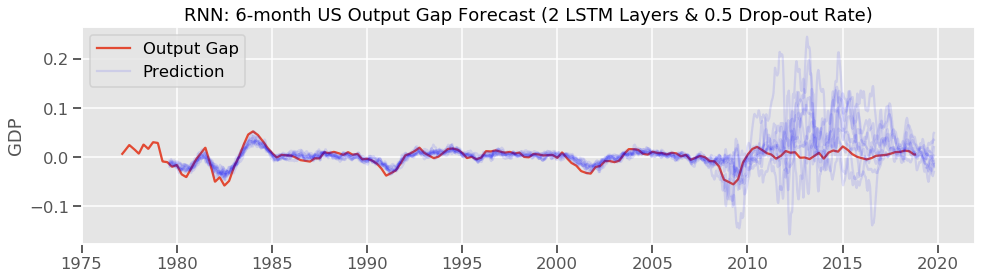

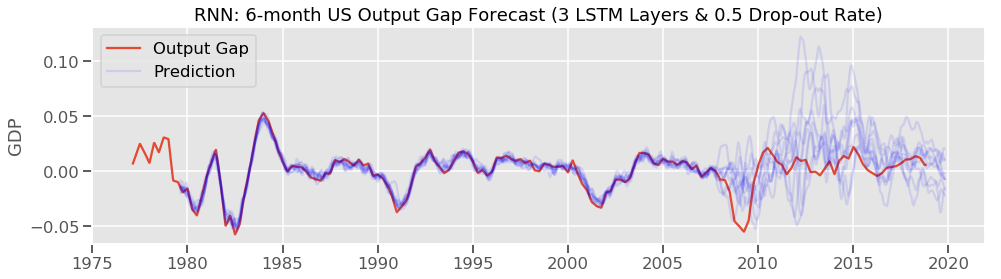

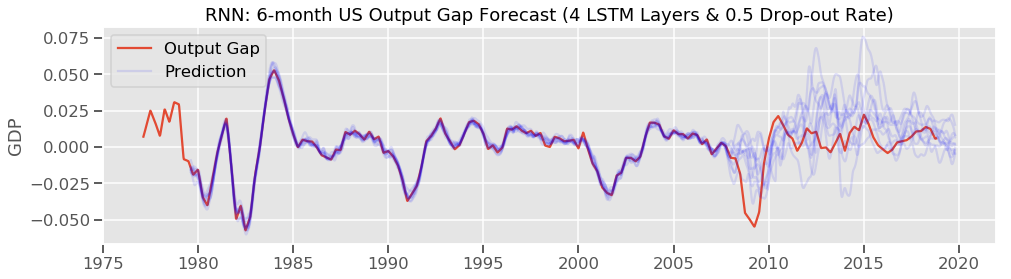

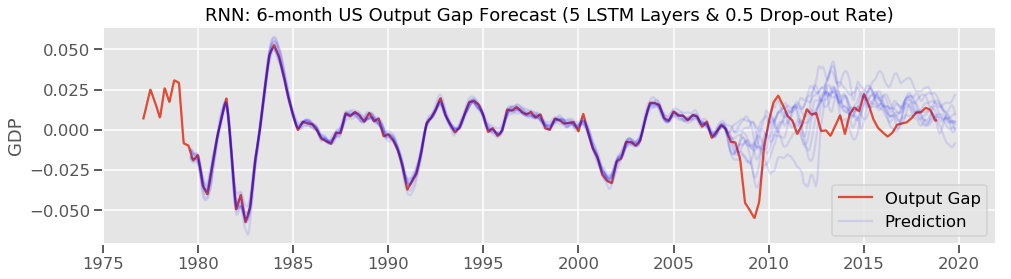

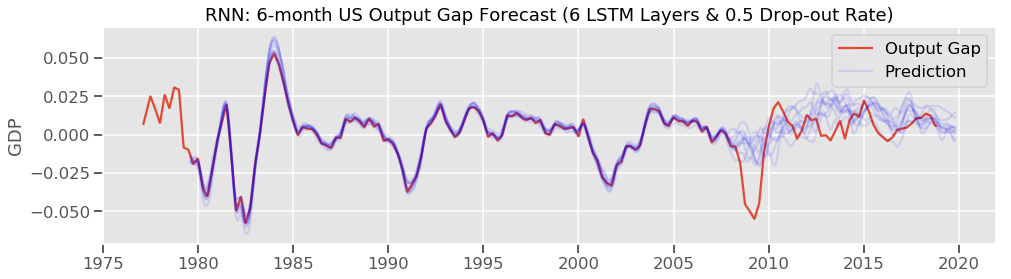

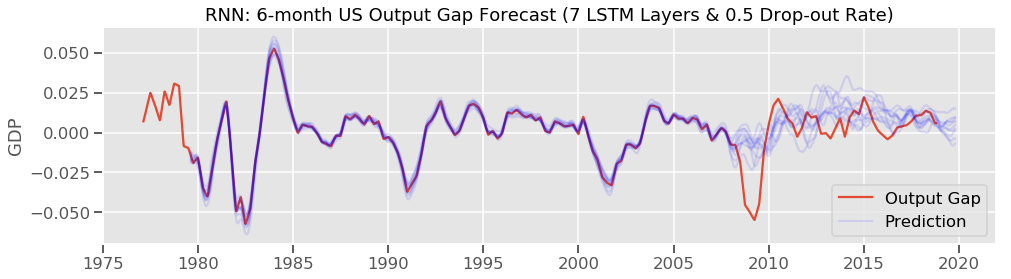

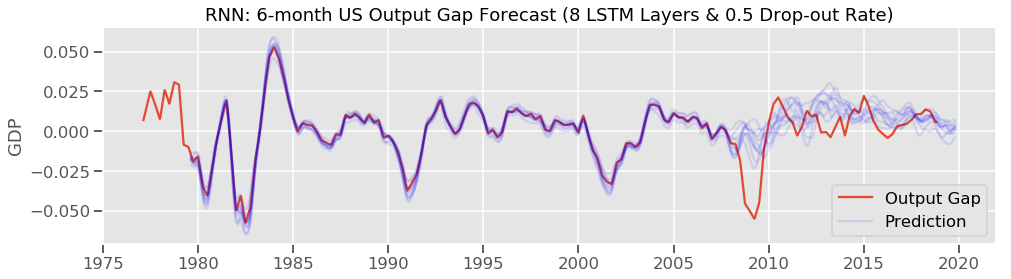

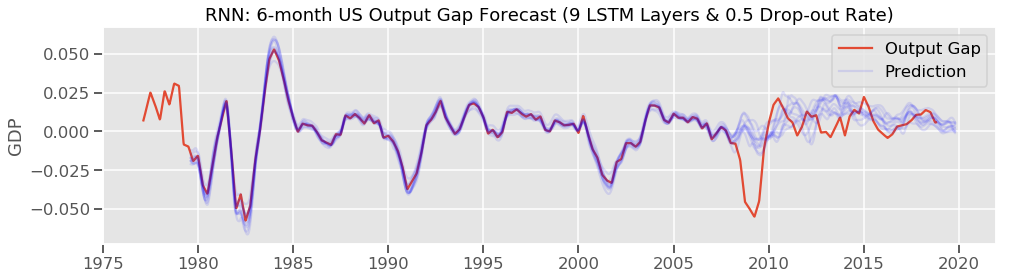

In [150]:
for key in pred_gap_df_dict_layer.keys():
    fig = plt.figure(figsize=(16,4))
    pred_each = pd.DataFrame(pred_gap_df_dict_layer[key].shift(26))
    ax = plt.plot(df_merged.gap[X_scaled.index])
    ax = plt.plot(pred_each, c="blue", alpha = 0.1)
    plt.title("RNN: 6-month US Output Gap Forecast ({} LSTM Layers & 0.5 Drop-out Rate)".format(key+2))
    plt.ylabel("GDP")
    plt.legend(["Output Gap", "Prediction"])
    plt.savefig("../images/6m_gap_rnn_{}_LSTM_0.5_dropout.png".format(key+2))
    plt.show()
    pred_each.to_csv("../data/{}_LSTM_0.5_DO.csv".format(key))

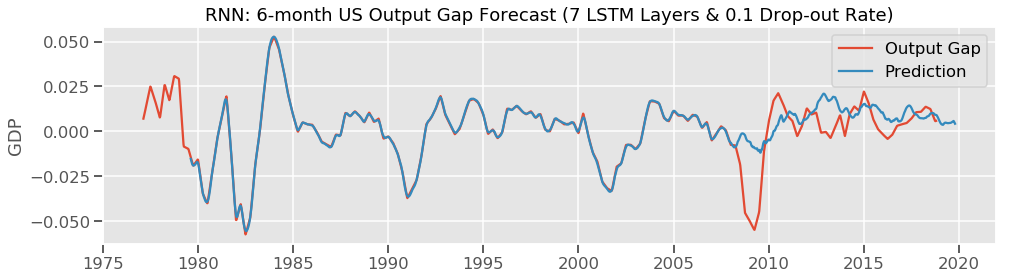

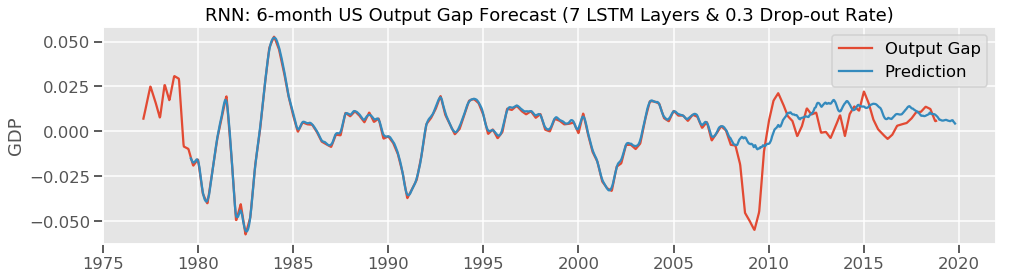

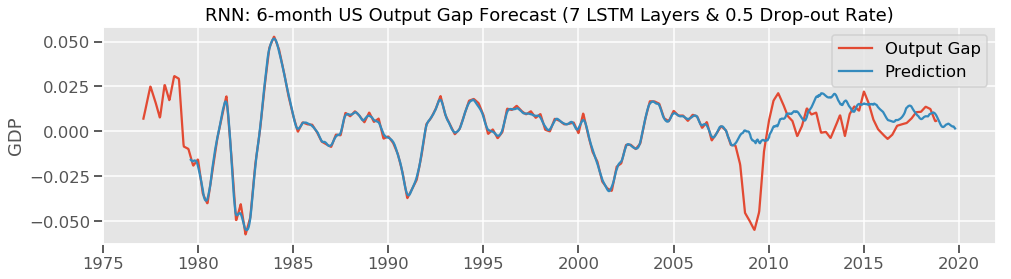

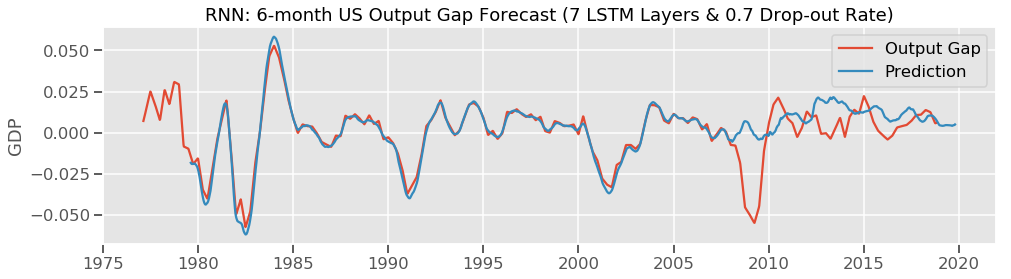

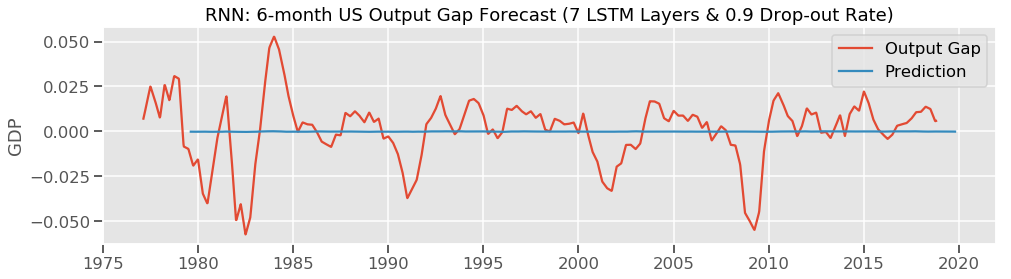

In [106]:
for key in pred_gap_df_dict.keys():
    fig = plt.figure(figsize=(16,4))
    pred_median = pd.DataFrame(pred_gap_df_dict[key].median(axis=1).shift(26))
    ax = plt.plot(df_merged.gap[X_scaled.index])
    ax = plt.plot(pred_median)
    plt.title("RNN: 6-month US Output Gap Forecast (7 LSTM Layers & {} Drop-out Rate)".format(key))
    plt.ylabel("GDP")
    plt.legend(["Output Gap", "Prediction"])

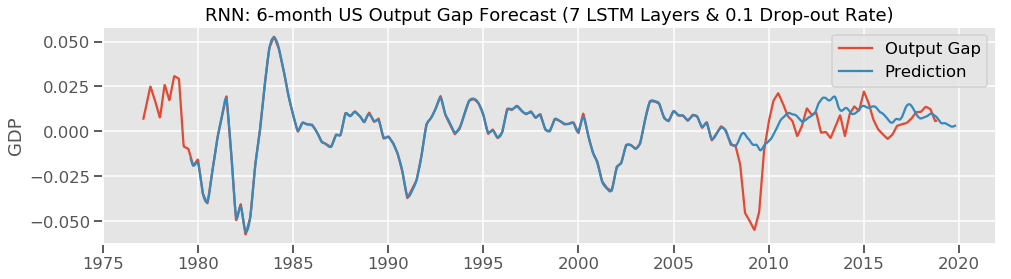

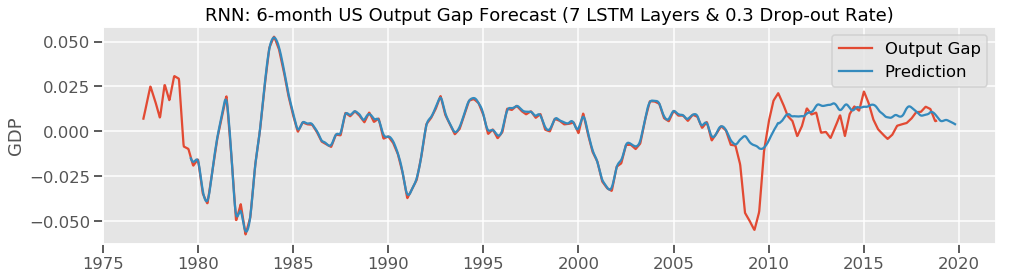

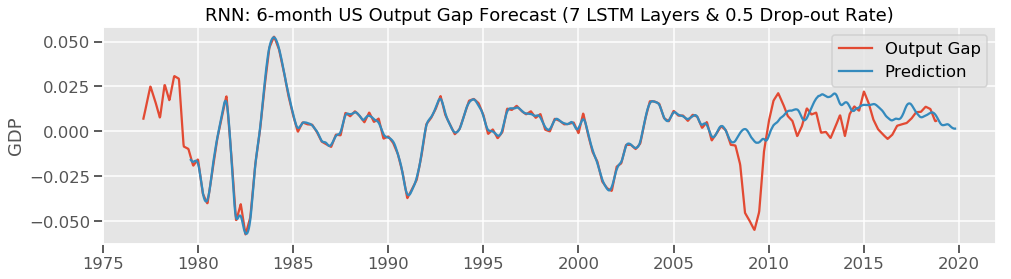

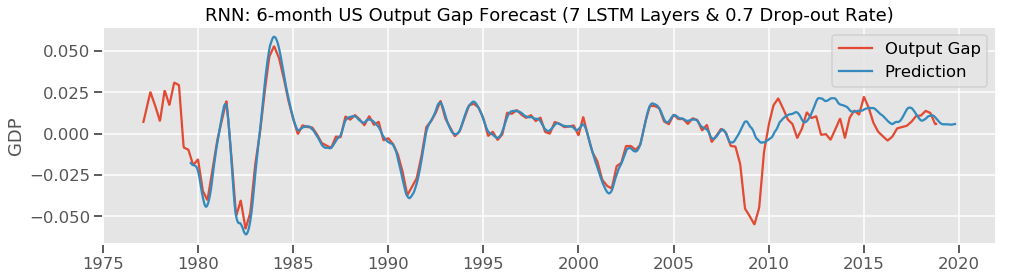

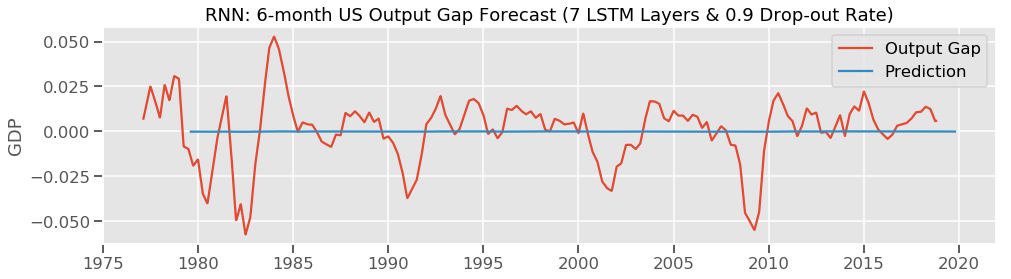

In [110]:
for key in pred_gap_df_dict.keys():
    fig = plt.figure(figsize=(16,4))
    pred_mean = pd.DataFrame(pred_gap_df_dict[key].mean(axis=1).shift(26))
    ax = plt.plot(df_merged.gap[X_scaled.index])
    ax = plt.plot(pred_mean)
    plt.title("RNN: 6-month US Output Gap Forecast (7 LSTM Layers & {} Drop-out Rate)".format(key))
    plt.ylabel("GDP")
    plt.legend(["Output Gap", "Prediction"])

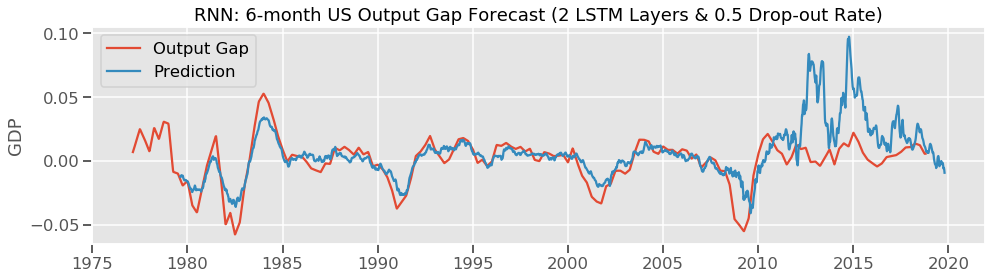

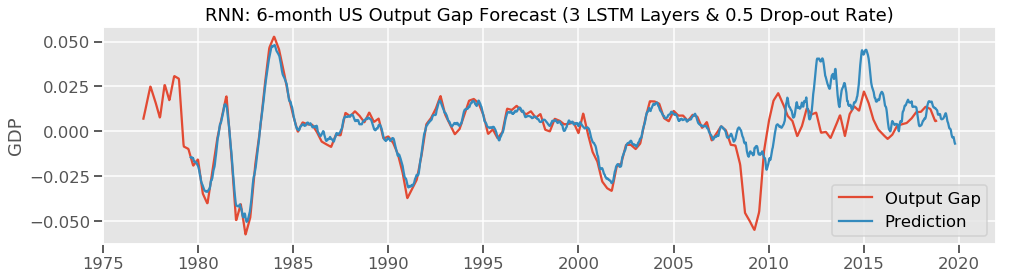

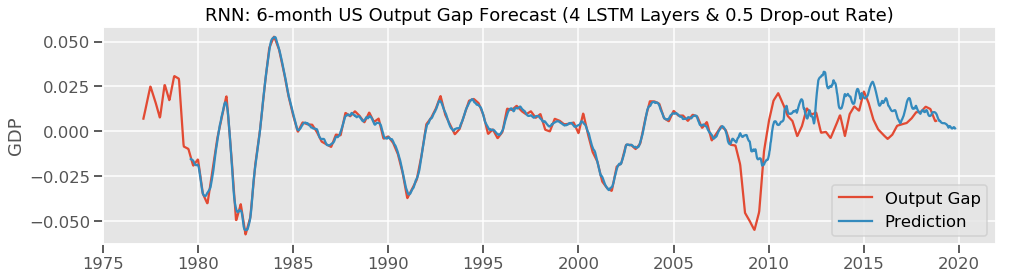

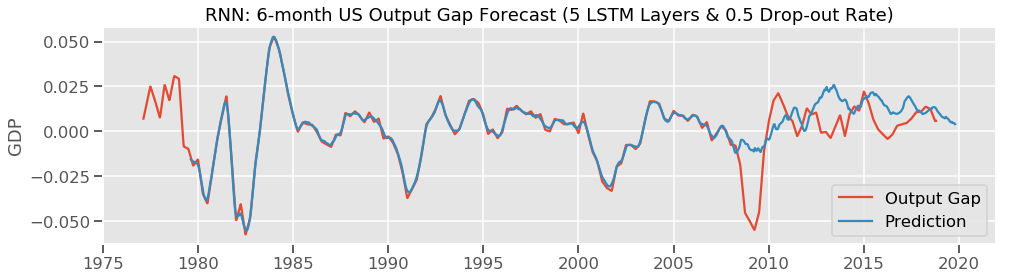

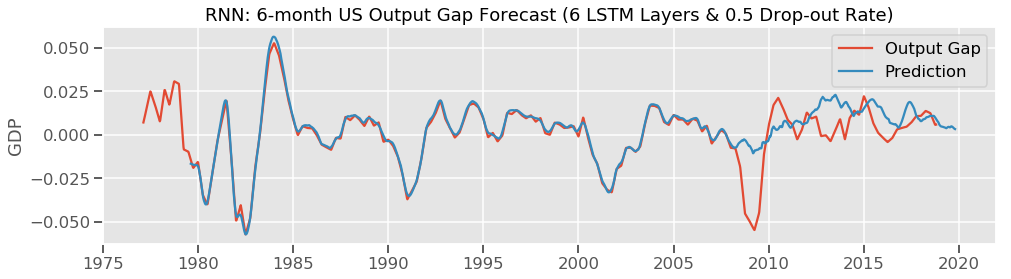

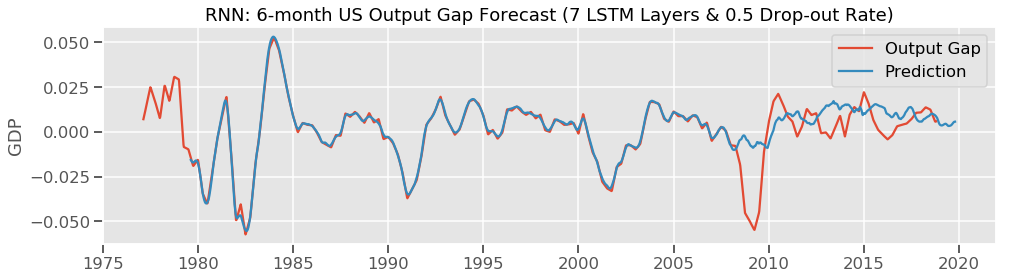

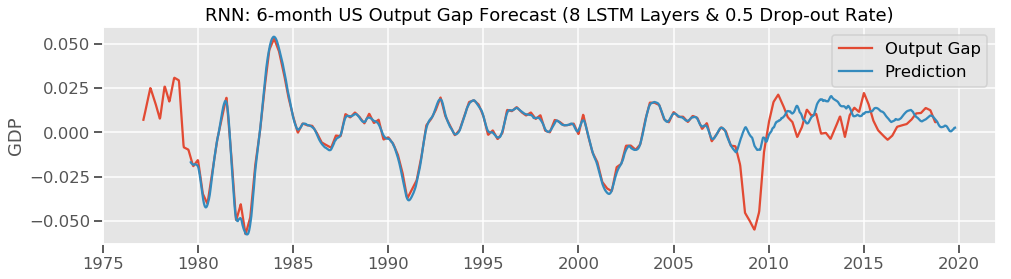

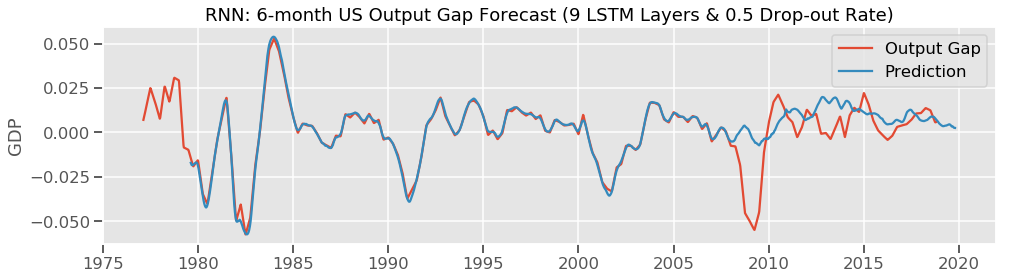

In [114]:
for key in pred_gap_df_dict_layer.keys():
    fig = plt.figure(figsize=(16,4))
    pred_median = pd.DataFrame(pred_gap_df_dict_layer[key].median(axis=1).shift(26))
    ax = plt.plot(df_merged.gap[X_scaled.index])
    ax = plt.plot(pred_median)
    plt.title("RNN: 6-month US Output Gap Forecast ({} LSTM Layers & 0.5 Drop-out Rate)".format(key+2))
    plt.ylabel("GDP")
    plt.legend(["Output Gap", "Prediction"])

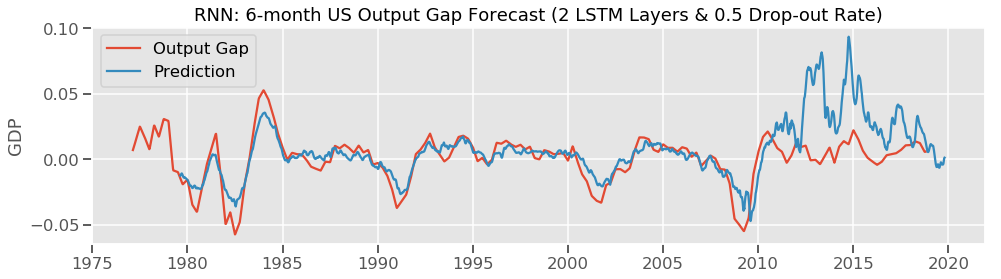

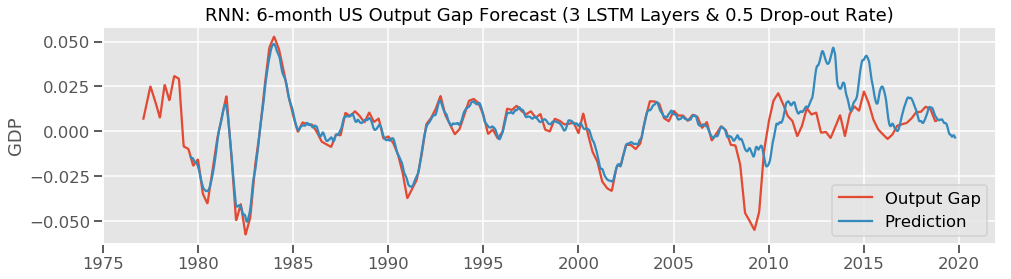

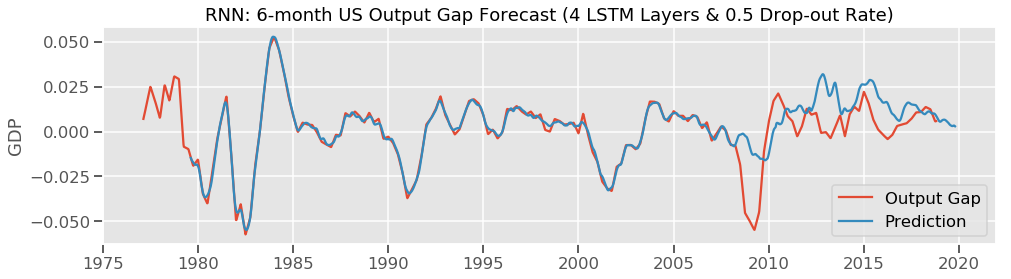

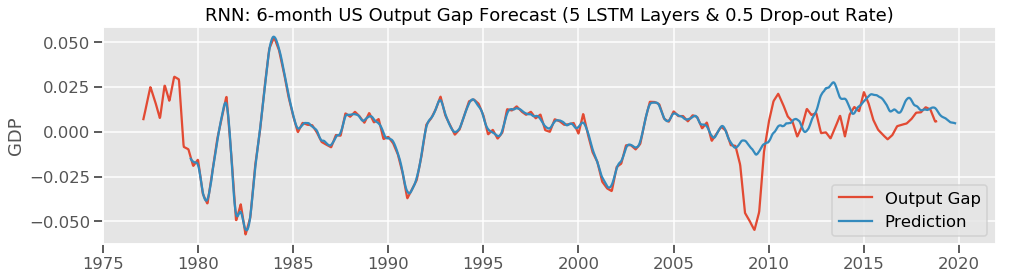

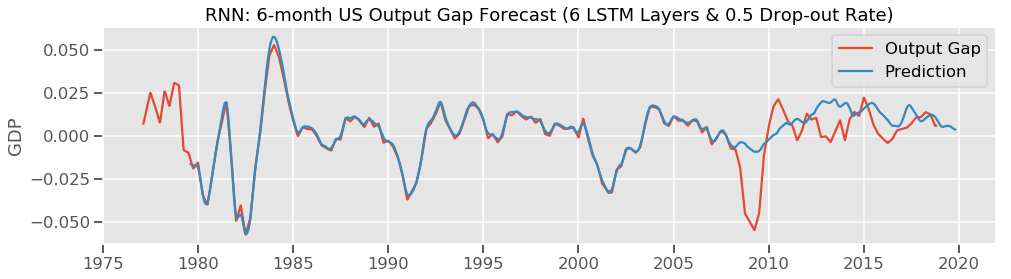

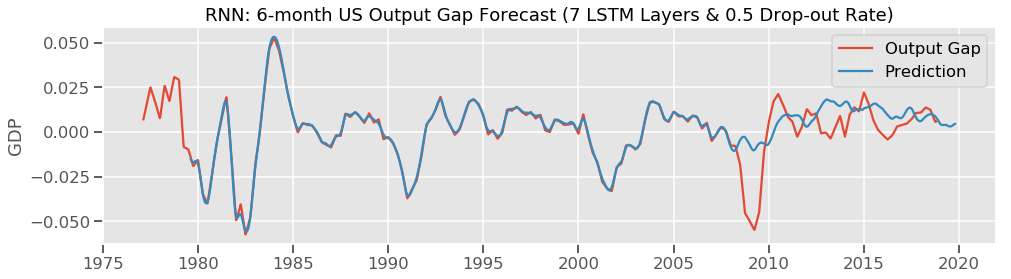

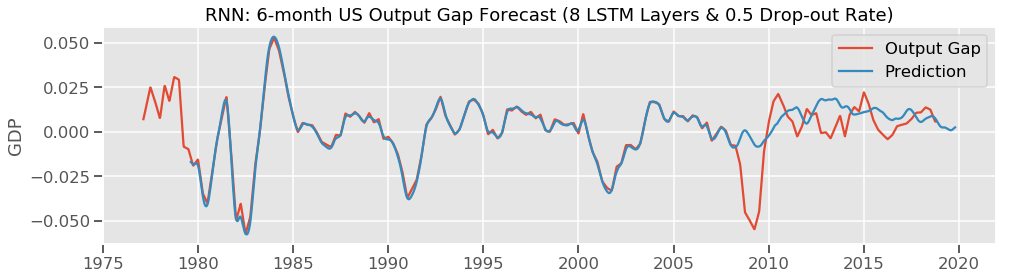

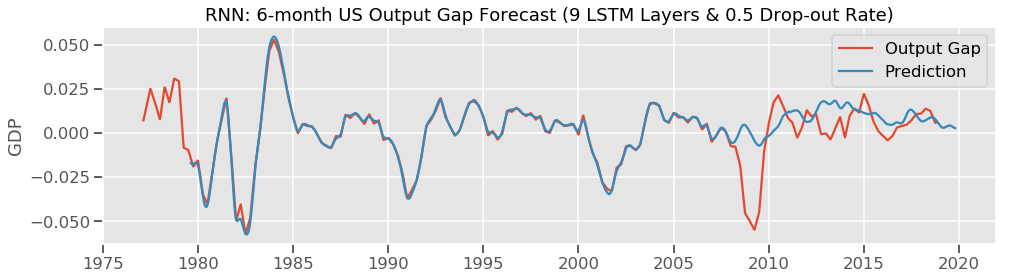

In [113]:
for key in pred_gap_df_dict_layer.keys():
    fig = plt.figure(figsize=(16,4))
    pred_mean = pd.DataFrame(pred_gap_df_dict_layer[key].mean(axis=1).shift(26))
    ax = plt.plot(df_merged.gap[X_scaled.index])
    ax = plt.plot(pred_mean)
    plt.title("RNN: 6-month US Output Gap Forecast ({} LSTM Layers & 0.5 Drop-out Rate)".format(key+2))
    plt.ylabel("GDP")
    plt.legend(["Output Gap", "Prediction"])

In [85]:
pd.merge(pd.DataFrame(pred_gap_df_dict[0.2].shift(26)), 
                     df_merged.gap[X_scaled.index].iloc[int(X_pca_rnn.shape[0]*0.7):], 
                     how="inner", 
                     left_index=True,
                     right_index=True).columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'gap'], dtype='object')

In [83]:
pd.merge(pd.DataFrame(pred_gap_df_dict[0.1].shift(26)), 
                     df_merged.gap[X_scaled.index].iloc[int(X_pca_rnn.shape[0]*0.7):], 
                     how="inner", 
                     left_index=True,
                     right_index=True).columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'gap'], dtype='object')

In [89]:
scores_dict = {}
for key in pred_gap_df_dict.keys():
    measurement_df = pd.merge(pd.DataFrame(pred_gap_df_dict[key].shift(26)), 
                     df_merged.gap[X_scaled.index].iloc[int(X_pca_rnn.shape[0]*0.7):], 
                     how="inner", 
                     left_index=True,
                     right_index=True)
    root_mean_sq_error = []
    for i in range(0,10):
        root_mean_sq_error.append((mean_squared_error(measurement_df.loc[:, i], measurement_df.gap))**0.5)
    scores_dict[key] = root_mean_sq_error

In [90]:
pd.DataFrame(scores_dict)

0.2       0.4       0.6       0.8       0.1       0.3       0.5  \
0  0.014923  0.016479  0.019424  0.018474  0.014833  0.017074  0.014633   
1  0.015557  0.019986  0.016779  0.015921  0.014698  0.012850  0.015954   
2  0.016104  0.016833  0.017452  0.020129  0.016158  0.013068  0.014621   
3  0.014319  0.016870  0.014848  0.021072  0.019576  0.015608  0.016994   
4  0.013612  0.014733  0.016017  0.020672  0.015119  0.016042  0.015670   
5  0.016951  0.014159  0.015151  0.020117  0.014532  0.016160  0.016891   
6  0.014557  0.017510  0.020536  0.019606  0.015420  0.014990  0.018137   
7  0.014967  0.014369  0.017592  0.027383  0.014862  0.012843  0.017317   
8  0.014070  0.015485  0.020868  0.024003  0.013257  0.014656  0.014850   
9  0.018627  0.016125  0.014810  0.022051  0.013806  0.013280  0.016030   

        0.7       0.9  
0  0.013904  0.016156  
1  0.022718  0.016171  
2  0.016254  0.016169  
3  0.019431  0.016297  
4  0.016638  0.016184  
5  0.017125  0.016183  
6  0.017560  0.016204  
7  0.016171  0.016164  
8  0.019286  0.016211  
9  0.022316  0.016209

In [103]:
list(lambda x/10 for x in range(1,10))

SyntaxError: invalid syntax (<ipython-input-103-552bbe872f21>, line 1)

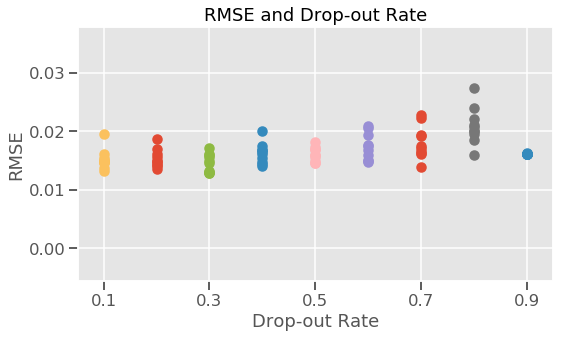

In [91]:
fig = plt.figure(figsize=(8, 4.8))
for i in pd.DataFrame(scores_dict).columns:
    plt.scatter(np.full(10, i),pd.DataFrame(scores_dict)[i])
plt.title("RMSE and Drop-out Rate")
plt.xlabel("Drop-out Rate")
plt.ylabel("RMSE")
plt.xticks([0.1, 0.3, 0.5, 0.7, 0.9])
plt.tight_layout()
plt.savefig("../images/drop_out_trial.png")

In [145]:
scores_layer_dict = {}
for key in pred_gap_df_dict_layer.keys():
    measurement_df = pd.merge(pd.DataFrame(pred_gap_df_dict_layer[key].shift(26)), 
                     df_merged.gap[X_scaled.index].iloc[int(X_pca_rnn.shape[0]*0.7):], 
                     how="inner", 
                     left_index=True,
                     right_index=True)
    root_mean_sq_error = []
    for i in range(0,10):
        root_mean_sq_error.append((mean_squared_error(measurement_df.loc[:, i], measurement_df.gap))**0.5)
    scores_layer_dict[key+2] = root_mean_sq_error

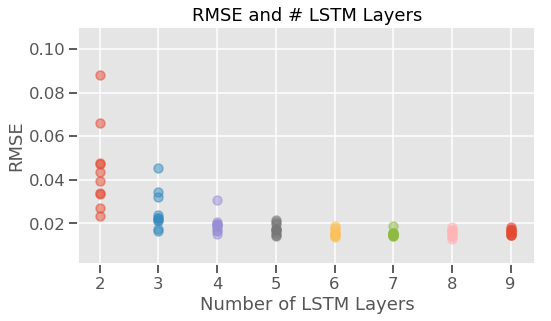

In [165]:
fig = plt.figure(figsize=(8, 4.8))
for i in pd.DataFrame(scores_layer_dict).columns:
    plt.scatter(np.full(10, i),pd.DataFrame(scores_layer_dict)[i], alpha=0.5)
plt.title("RMSE and # LSTM Layers")
plt.xlabel("Number of LSTM Layers")
plt.ylabel("RMSE")
plt.xticks(range(2, 10))
plt.tight_layout()
plt.savefig("../images/LSTM_layer_trial.png")